# Towards Context based adaptive learning with WGNs

## 1. Extended labels sequential learning - ada = 0.5 (Half adaptive)

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-05-15 01:37:57.764641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 01:37:58.807110: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-15 01:37:58.807666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-15 01:37:58.845265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-15 01:37:58.845321: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 01:37:58.848691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-

In [2]:
import tensorflow as tf
from tensorflow import keras 

In [3]:
import numpy as np

input_dim = 784
classes = 20

main_network = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 256 + classes) + (256 * input_dim + 256)

# hypernetwork that generates the weights of the `main_network.
hypernetwork = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

2024-05-15 01:37:58.888748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 01:37:58.890199: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-15 01:37:58.890835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-15 01:37:58.890857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 01:37:58.890884: I tensorflow/stream_executor/platform/de

In [4]:
import numpy as np

# Prepare dataset 1.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

a = np.zeros((len(y_train),1))
b = np.zeros((len(y_test),1))

for i in range(10):
    y_train = np.hstack((y_train, a))
    y_test = np.hstack((y_test, b))


train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train.reshape(60000, 20))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test.reshape(10000, 20))
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(1)




In [5]:
# Prepare dataset 2.
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()

# convert class vectors to binary class matrices
fy_train = keras.utils.to_categorical(fy_train, 10)
fy_test = keras.utils.to_categorical(fy_test, 10)

a = np.zeros((len(fy_train),1))
b = np.zeros((len(fy_test),1))

for i in range(10):
    fy_train = np.hstack((a,fy_train))
    fy_test = np.hstack((b,fy_test))


ftrain_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_train.reshape(60000, 784).astype("float32") / 255, fy_train.reshape(60000, 20))
)
ftest_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_test.reshape(10000, 784).astype("float32") / 255, fy_test.reshape(10000, 20))
)

ftrain_dataset = ftrain_dataset.shuffle(buffer_size=1024).batch(1)
ftest_dataset = ftest_dataset.shuffle(buffer_size=1024).batch(1)

In [6]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD()

#@tf.function
def train_step(x, y, step, ada = 1):
    with tf.GradientTape() as tape:
        if step == 0:
            weights_init = tf.random.uniform((1,num_weights_to_generate))
            # Reshape them to the expected shapes for w and b for the outer model.
            # Layer 0 kernel.
            start_index = 0
            w0_shape = (input_dim, 256)
            w0_coeffs = weights_init[:, start_index : start_index + np.prod(w0_shape)]
            w0 = tf.reshape(w0_coeffs, w0_shape)
            start_index += np.prod(w0_shape)
            # Layer 0 bias.
            b0_shape = (256,)
            b0_coeffs = weights_init[:, start_index : start_index + np.prod(b0_shape)]
            b0 = tf.reshape(b0_coeffs, b0_shape)
            start_index += np.prod(b0_shape)
            # Layer 1 kernel.
            w1_shape = (256, classes)
            w1_coeffs = weights_init[:, start_index : start_index + np.prod(w1_shape)]
            w1 = tf.reshape(w1_coeffs, w1_shape)
            start_index += np.prod(w1_shape)
            # Layer 1 bias.
            b1_shape = (classes,)
            b1_coeffs = weights_init[:, start_index : start_index + np.prod(b1_shape)]
            b1 = tf.reshape(b1_coeffs, b1_shape)
            start_index += np.prod(b1_shape)

            main_network.layers[0].kernel = w0
            main_network.layers[0].bias = b0
            main_network.layers[1].kernel = w1
            main_network.layers[1].bias = b1
        
        # Predict weights for the outer model.
        weights_pred = hypernetwork(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 256)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (256,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (256, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        
        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
        main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
        main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
        main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1
        
        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, hypernetwork.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernetwork.trainable_weights))
    return loss, train_acc



In [7]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

#@tf.function
def test_step(x, y, ada = 1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds

In [31]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 2
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        loss, train_acc = train_step(x, y, step, 0.5)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%1000 == 0:
                print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(test_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 0.5)
                test_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    
    acc_fn.reset_states()

Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 2593.3994140625 Train Acc: tf.Tensor(0.5, shape=(), dtype=float32) Test Acc: tf.Tensor(0.09929007, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 1.2616008223538688 Train Acc: tf.Tensor(0.74995, shape=(), dtype=float32) Test Acc: tf.Tensor(0.7548, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in 

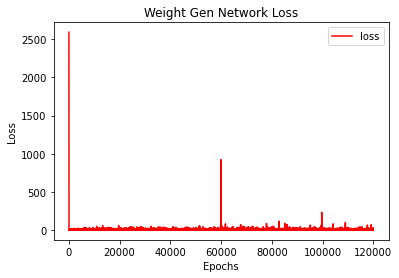

In [32]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


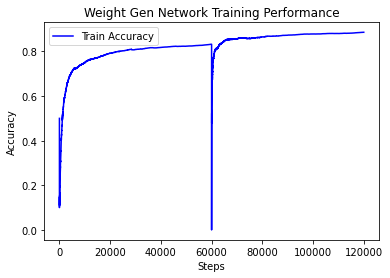

In [33]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

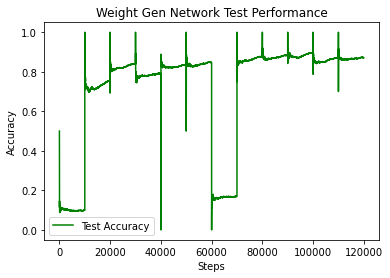

In [34]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
#savemodel
hypernetwork.save("WGNada_Mnist.h5")
with open('WGNada_Mnist_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('WGNada_Mnist_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('WGNada_Mnist_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))


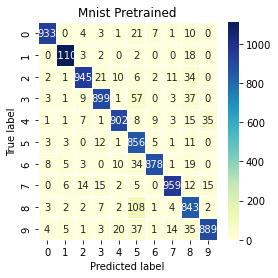

In [35]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

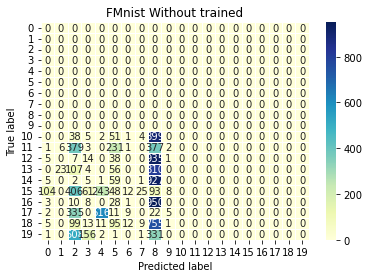

In [36]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Without trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
weights_pred = hypernetwork(x_train.reshape(60000,1,784)[0])

hypernetwork.load_weights("WGNada_Mnist.h5")

# Reshape them to the expected shapes for w and b for the outer model.
# Layer 0 kernel.
start_index = 0
w0_shape = (input_dim, 256)
w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
w0 = tf.reshape(w0_coeffs, w0_shape)
start_index += np.prod(w0_shape)
# Layer 0 bias.
b0_shape = (256,)
b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
b0 = tf.reshape(b0_coeffs, b0_shape)
start_index += np.prod(b0_shape)
# Layer 1 kernel.
w1_shape = (256, classes)
w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
w1 = tf.reshape(w1_coeffs, w1_shape)
start_index += np.prod(w1_shape)
# Layer 1 bias.
b1_shape = (classes,)
b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
b1 = tf.reshape(b1_coeffs, b1_shape)
start_index += np.prod(b1_shape)

# Set the weight predictions as the weight variables on the outer model.
main_network.layers[0].kernel = w0
main_network.layers[0].bias = b0
main_network.layers[1].kernel = w1
main_network.layers[1].bias = b1

preds = main_network(x_train.reshape(60000,1,784)[0])


In [32]:
from tensorflow.keras import backend as K

# here X is param 1 (input) and the function returns output from layers
# Inference on the outer model.
get_layer_output = K.function(
  [main_network.layers[0].input], # param 1 will be treated as layer[0].output
  [main_network.layers[1].output]) 

eval_fn = tf.keras.metrics.CategoricalAccuracy()

def eval_step(x, y, ada=1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    lyr = get_layer_output(x)
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    eval_fn.update_state(y, preds)    
    evalacc = eval_fn.result()
 
    return evalacc, lyr, preds, weights_pred

In [33]:
import umap
import umap.plot
sz=10000

imgs = x_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = y_train[:sz].reshape(sz, 1, 20)

weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

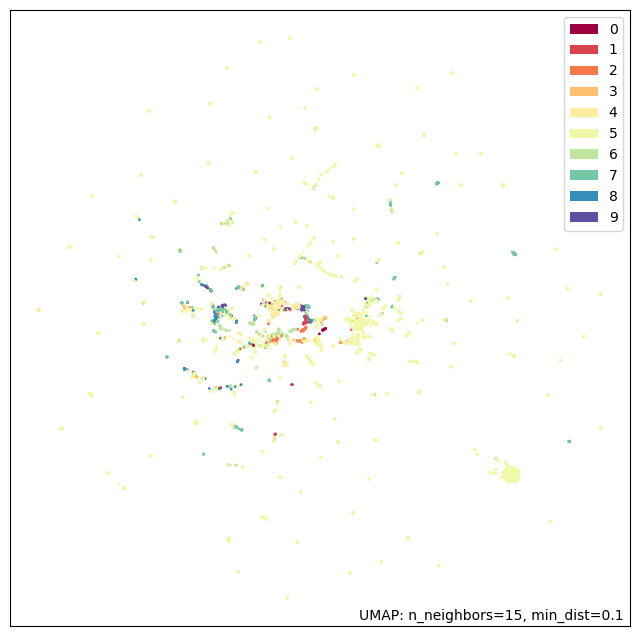

In [34]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

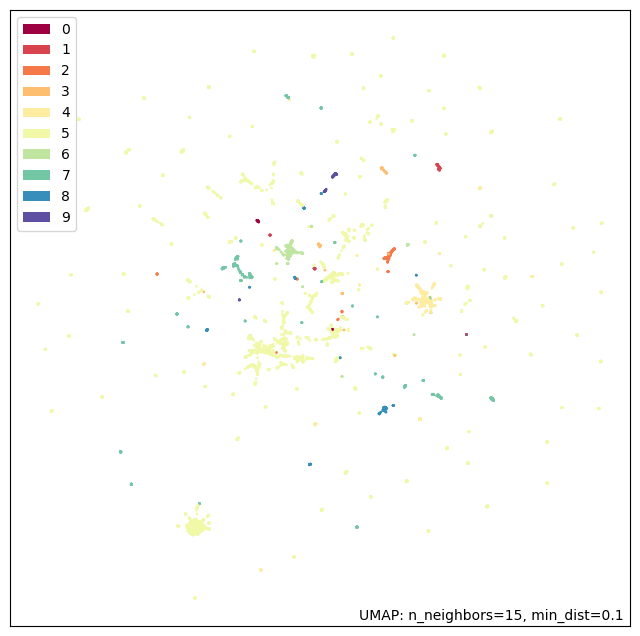

In [35]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

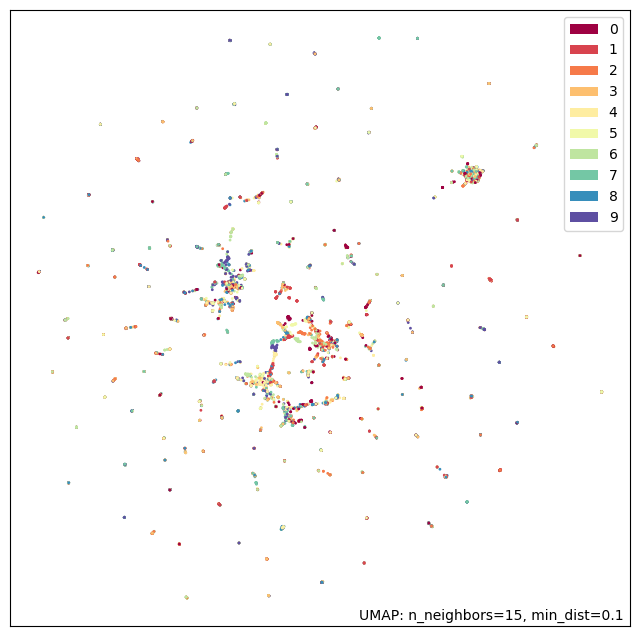

In [36]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

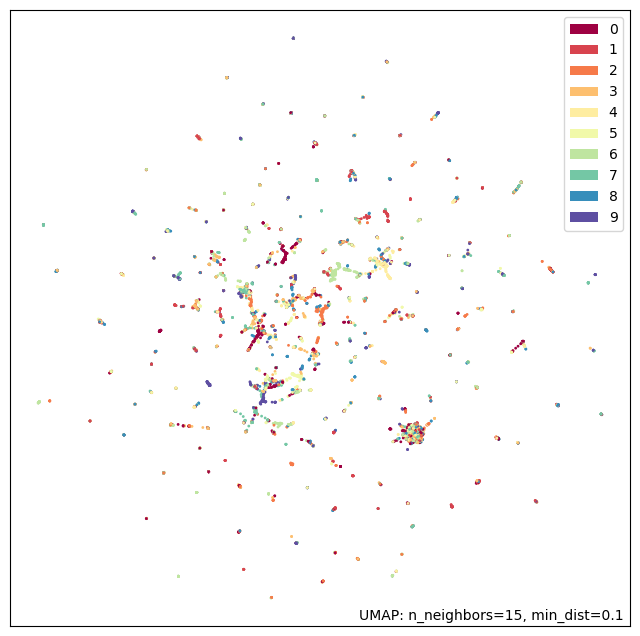

In [37]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

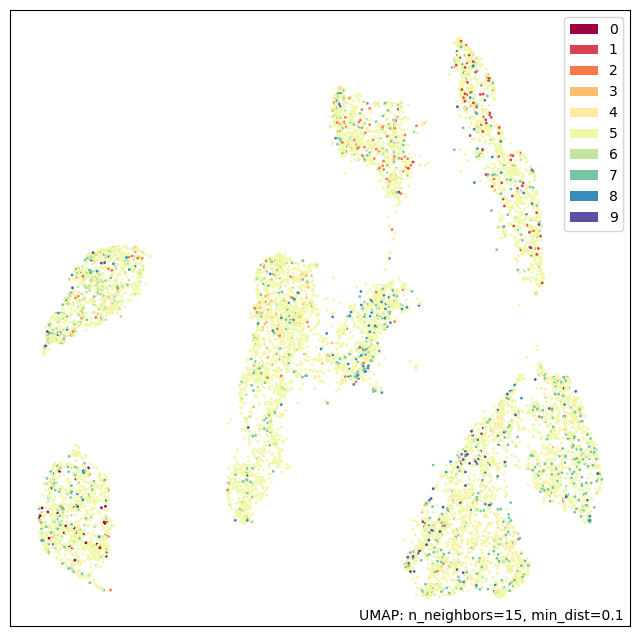

In [38]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [10]:
#Train fMNIST sequentially on top of MNIST

In [11]:
cloned_hypernetwork = tf.keras.models.clone_model(hypernetwork)

In [12]:
flosses = []  # Keep track of the losses over time.
ftrain_accs = []
ftest_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 2
for i in range(epochs):
    for step, (x, y) in enumerate(ftrain_dataset):
        loss, train_acc = train_step(x, y, step, 0.5)
    
        # Logging.
        flosses.append(float(loss))
        ftrain_accs.append(train_acc)
        if step%1000 == 0:
            print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(ftest_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 0.5)
                ftest_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(flosses) / len(flosses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    acc_fn.reset_states()



Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 10.252792358398438 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 2.33908154626626 Train Acc: tf.Tensor(0.18728127, shape=(), dtype=float32) Test Acc: tf.Tensor(0.2675, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in pro

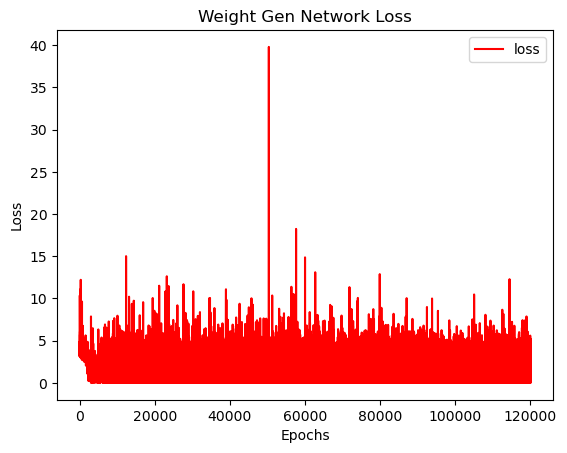

In [13]:
import matplotlib.pyplot as plt

plt.plot(flosses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


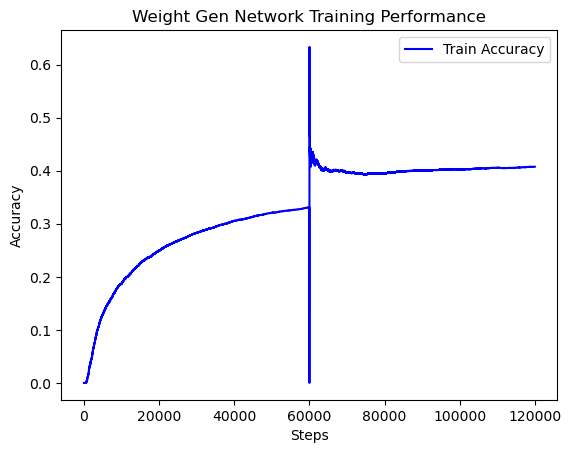

In [14]:
import matplotlib.pyplot as plt

plt.plot(ftrain_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

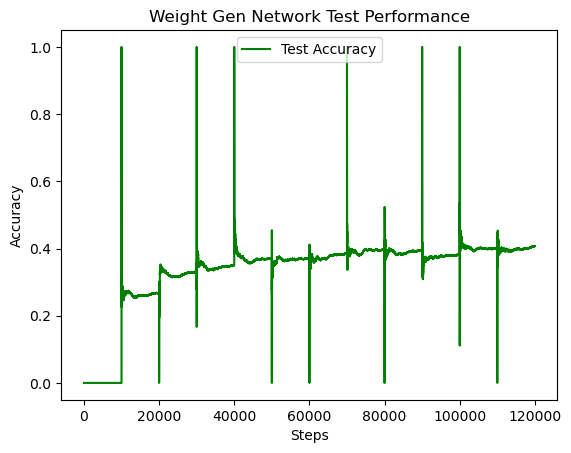

In [15]:
plt.plot(ftest_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

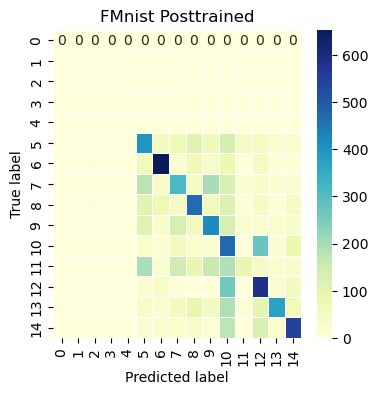

In [16]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Posttrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

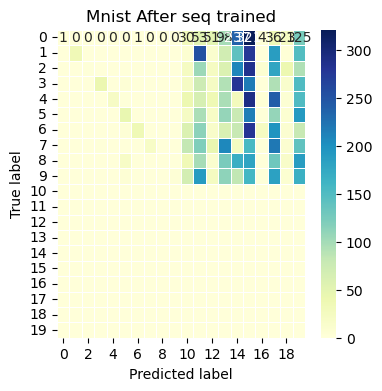

In [17]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist After seq trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
import umap
import umap.plot
sz=10000
imgs = fx_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = fy_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

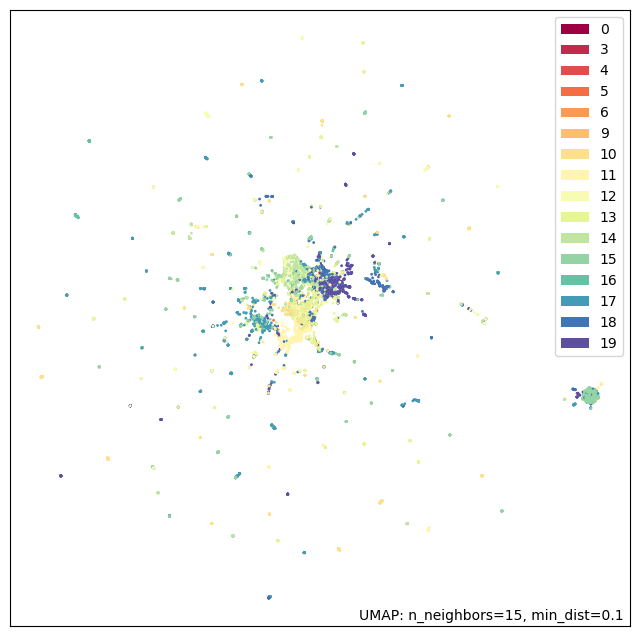

In [23]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

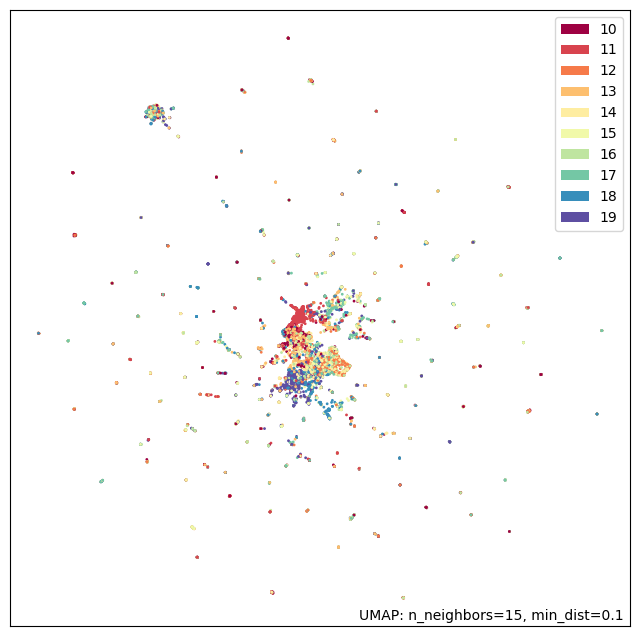

In [25]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(fy_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

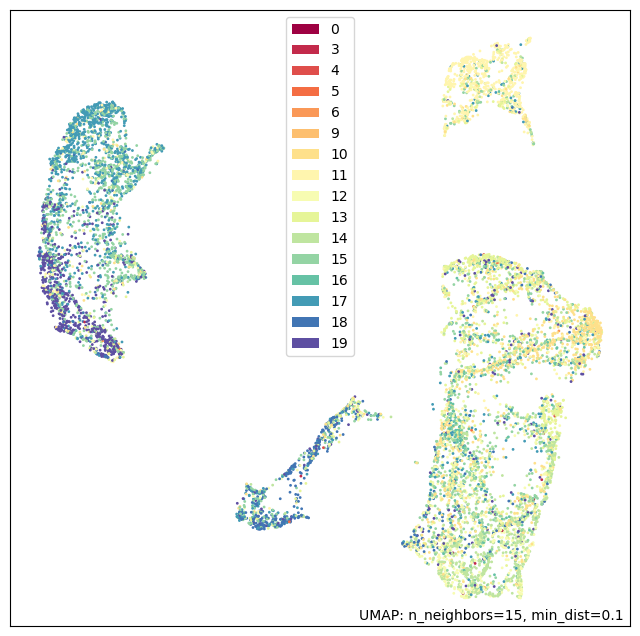

In [27]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

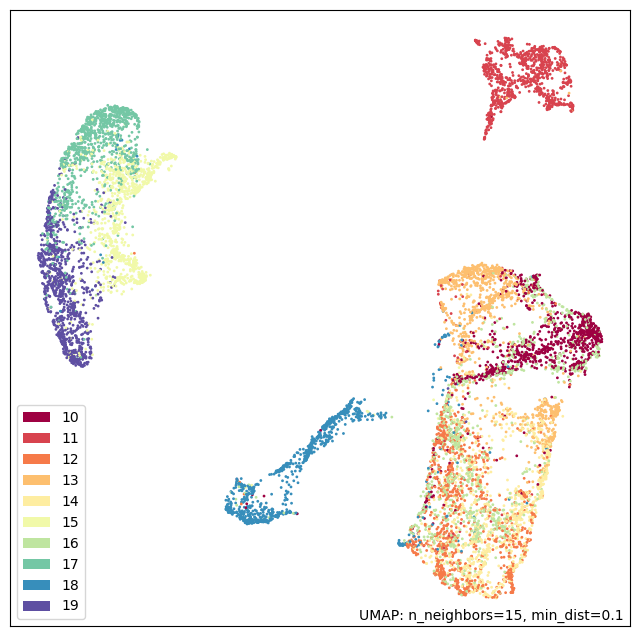

In [30]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels =  np.argmax(fy_train[:sz].reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

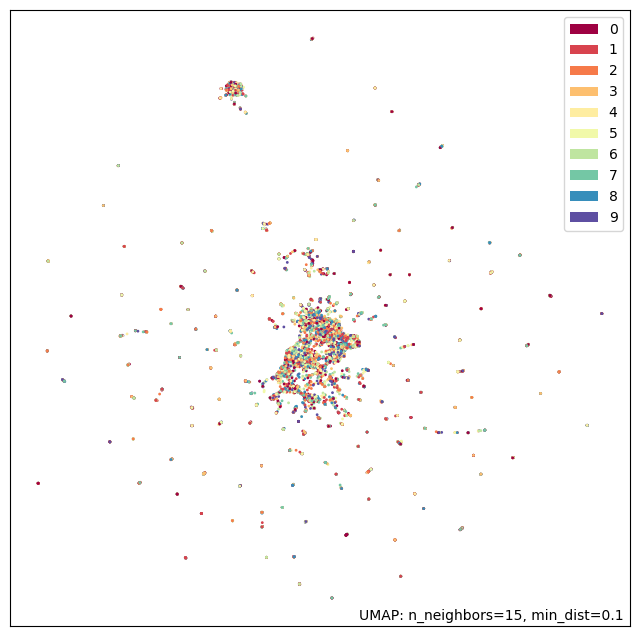

In [28]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

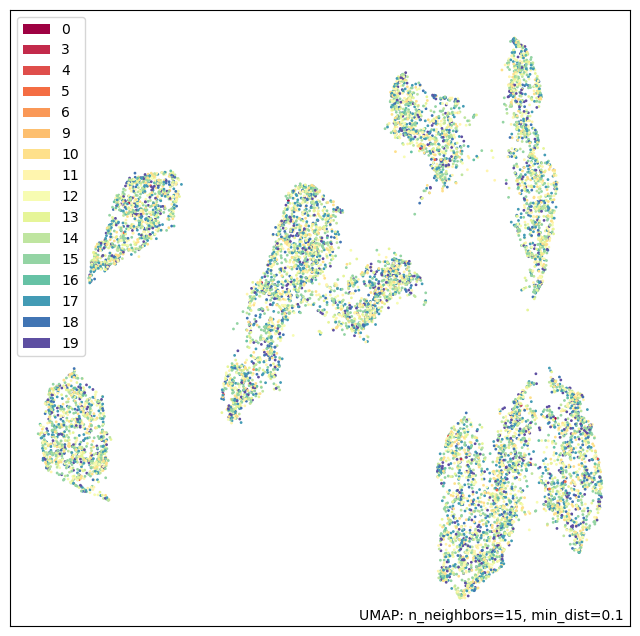

In [29]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

## Extended labels ada = 1 (Full adaptive)

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-05-15 03:19:54.043960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 03:19:55.057812: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-15 03:19:55.058390: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-15 03:19:55.114615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-15 03:19:55.114659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 03:19:55.117106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-

In [2]:
import tensorflow as tf
from tensorflow import keras 

In [3]:
import numpy as np

input_dim = 784
classes = 20

main_network = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 256 + classes) + (256 * input_dim + 256)

# hypernetwork that generates the weights of the `main_network.
hypernetwork = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

2024-05-15 03:19:59.147728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 03:19:59.150211: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-15 03:19:59.151742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-15 03:19:59.151804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-15 03:19:59.151876: I tensorflow/stream_executor/platform/de

In [4]:
import numpy as np

# Prepare dataset 1.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

a = np.zeros((len(y_train),1))
b = np.zeros((len(y_test),1))

for i in range(10):
    y_train = np.hstack((y_train, a))
    y_test = np.hstack((y_test, b))


train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train.reshape(60000, 20))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test.reshape(10000, 20))
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(1)




In [5]:
# Prepare dataset 2.
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()

# convert class vectors to binary class matrices
fy_train = keras.utils.to_categorical(fy_train, 10)
fy_test = keras.utils.to_categorical(fy_test, 10)

a = np.zeros((len(fy_train),1))
b = np.zeros((len(fy_test),1))

for i in range(10):
    fy_train = np.hstack((a,fy_train))
    fy_test = np.hstack((b,fy_test))


ftrain_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_train.reshape(60000, 784).astype("float32") / 255, fy_train.reshape(60000, 20))
)
ftest_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_test.reshape(10000, 784).astype("float32") / 255, fy_test.reshape(10000, 20))
)

ftrain_dataset = ftrain_dataset.shuffle(buffer_size=1024).batch(1)
ftest_dataset = ftest_dataset.shuffle(buffer_size=1024).batch(1)

In [6]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD()

#@tf.function
def train_step(x, y, step, ada = 1):
    with tf.GradientTape() as tape:
        if step == 0:
            weights_init = tf.random.uniform((1,num_weights_to_generate))
            # Reshape them to the expected shapes for w and b for the outer model.
            # Layer 0 kernel.
            start_index = 0
            w0_shape = (input_dim, 256)
            w0_coeffs = weights_init[:, start_index : start_index + np.prod(w0_shape)]
            w0 = tf.reshape(w0_coeffs, w0_shape)
            start_index += np.prod(w0_shape)
            # Layer 0 bias.
            b0_shape = (256,)
            b0_coeffs = weights_init[:, start_index : start_index + np.prod(b0_shape)]
            b0 = tf.reshape(b0_coeffs, b0_shape)
            start_index += np.prod(b0_shape)
            # Layer 1 kernel.
            w1_shape = (256, classes)
            w1_coeffs = weights_init[:, start_index : start_index + np.prod(w1_shape)]
            w1 = tf.reshape(w1_coeffs, w1_shape)
            start_index += np.prod(w1_shape)
            # Layer 1 bias.
            b1_shape = (classes,)
            b1_coeffs = weights_init[:, start_index : start_index + np.prod(b1_shape)]
            b1 = tf.reshape(b1_coeffs, b1_shape)
            start_index += np.prod(b1_shape)

            main_network.layers[0].kernel = w0
            main_network.layers[0].bias = b0
            main_network.layers[1].kernel = w1
            main_network.layers[1].bias = b1
        
        # Predict weights for the outer model.
        weights_pred = hypernetwork(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 256)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (256,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (256, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        
        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
        main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
        main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
        main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1
        
        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, hypernetwork.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernetwork.trainable_weights))
    return loss, train_acc



In [7]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

#@tf.function
def test_step(x, y, ada = 1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds

In [8]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        loss, train_acc = train_step(x, y, step, 1)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%1000 == 0:
                print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(test_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 1)
                test_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    
    acc_fn.reset_states()

2024-05-15 03:20:38.980911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 2.9770100116729736 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0982, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 0.6224352931349053 Train Acc: tf.Tensor(0.83551645, shape=(), dtype=float32) Test Acc: tf.Tensor(0.877, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in

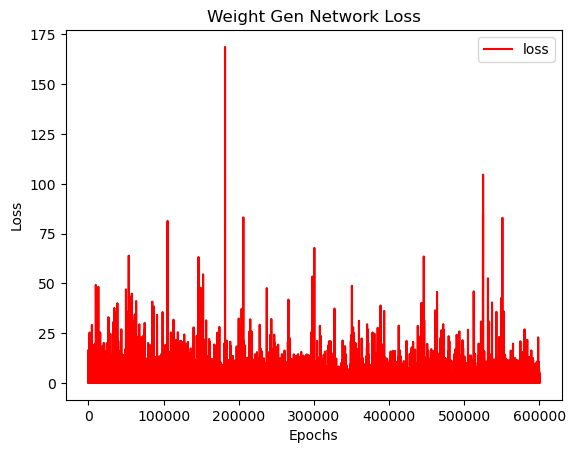

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


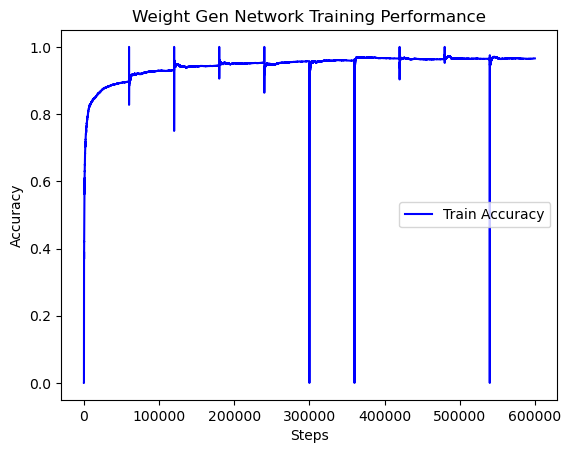

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

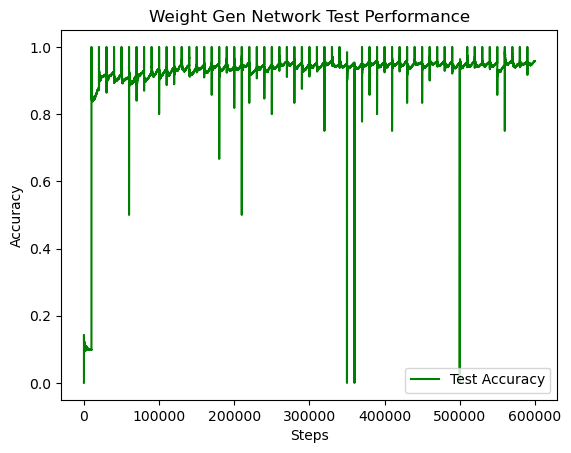

In [11]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
#savemodel
hypernetwork.save("WGNadafull_Mnist.h5")
with open('WGNadafull_Mnist_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('WGNadafull_Mnist_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('WGNadafull_Mnist_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))


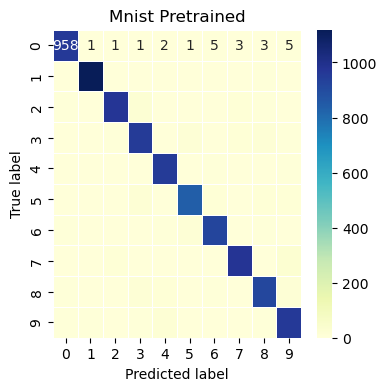

In [13]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

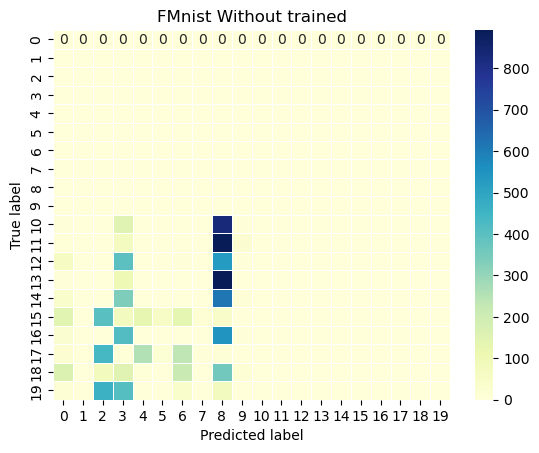

In [14]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Without trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
weights_pred = hypernetwork(x_train.reshape(60000,1,784)[0])

hypernetwork.load_weights("WGNadafull_Mnist.h5")

# Reshape them to the expected shapes for w and b for the outer model.
# Layer 0 kernel.
start_index = 0
w0_shape = (input_dim, 256)
w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
w0 = tf.reshape(w0_coeffs, w0_shape)
start_index += np.prod(w0_shape)
# Layer 0 bias.
b0_shape = (256,)
b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
b0 = tf.reshape(b0_coeffs, b0_shape)
start_index += np.prod(b0_shape)
# Layer 1 kernel.
w1_shape = (256, classes)
w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
w1 = tf.reshape(w1_coeffs, w1_shape)
start_index += np.prod(w1_shape)
# Layer 1 bias.
b1_shape = (classes,)
b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
b1 = tf.reshape(b1_coeffs, b1_shape)
start_index += np.prod(b1_shape)

# Set the weight predictions as the weight variables on the outer model.
main_network.layers[0].kernel = w0
main_network.layers[0].bias = b0
main_network.layers[1].kernel = w1
main_network.layers[1].bias = b1

preds = main_network(x_train.reshape(60000,1,784)[0])


In [16]:
from tensorflow.keras import backend as K

# here X is param 1 (input) and the function returns output from layers
# Inference on the outer model.
get_layer_output = K.function(
  [main_network.layers[0].input], # param 1 will be treated as layer[0].output
  [main_network.layers[1].output]) 

eval_fn = tf.keras.metrics.CategoricalAccuracy()

def eval_step(x, y, ada=1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    lyr = get_layer_output(x)
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    eval_fn.update_state(y, preds)    
    evalacc = eval_fn.result()
 
    return evalacc, lyr, preds, weights_pred

In [17]:
import umap
import umap.plot
sz=10000

imgs = x_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = y_train[:sz].reshape(sz, 1, 20)

weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

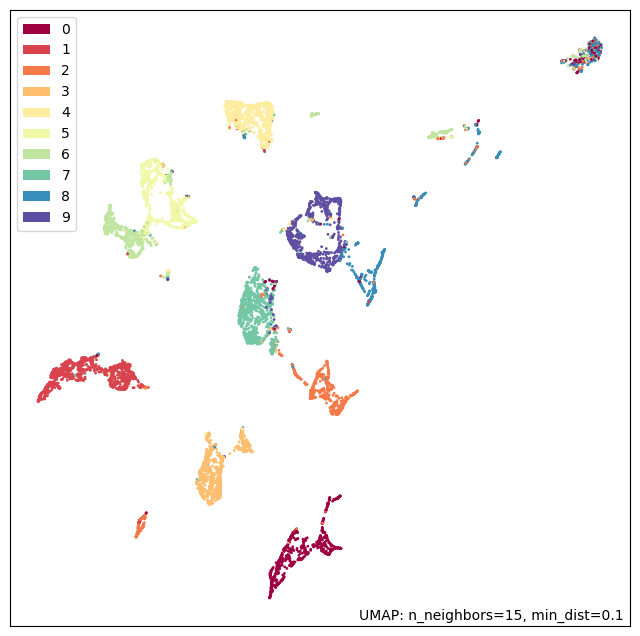

In [18]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

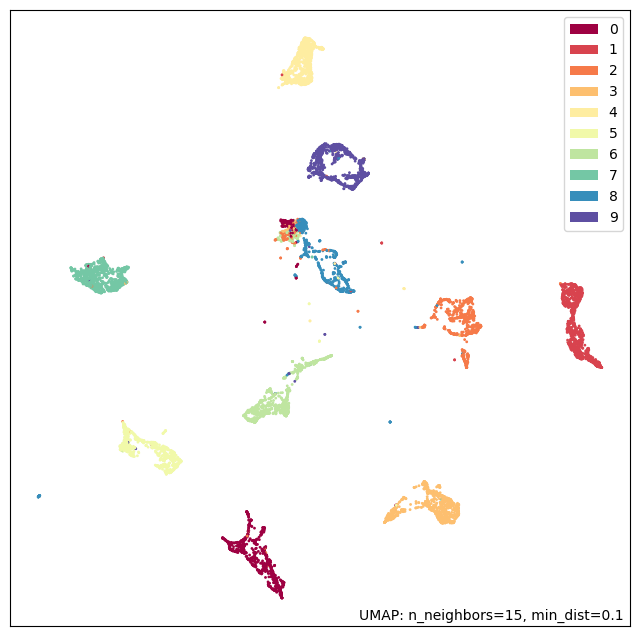

In [19]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

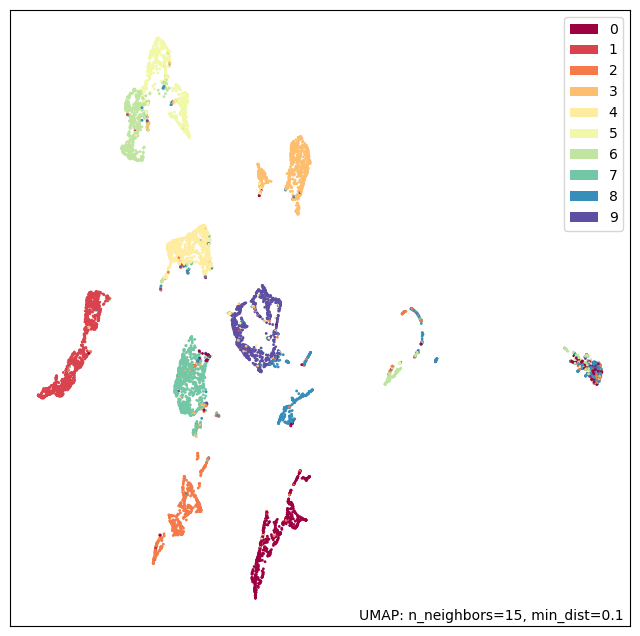

In [20]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

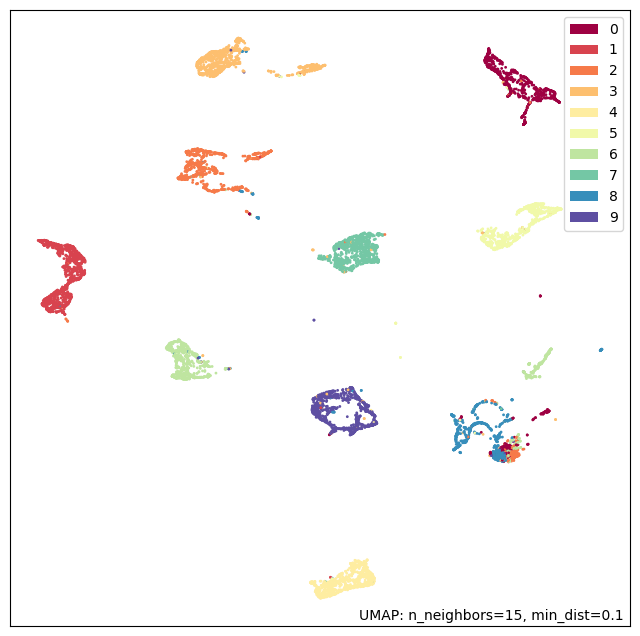

In [21]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

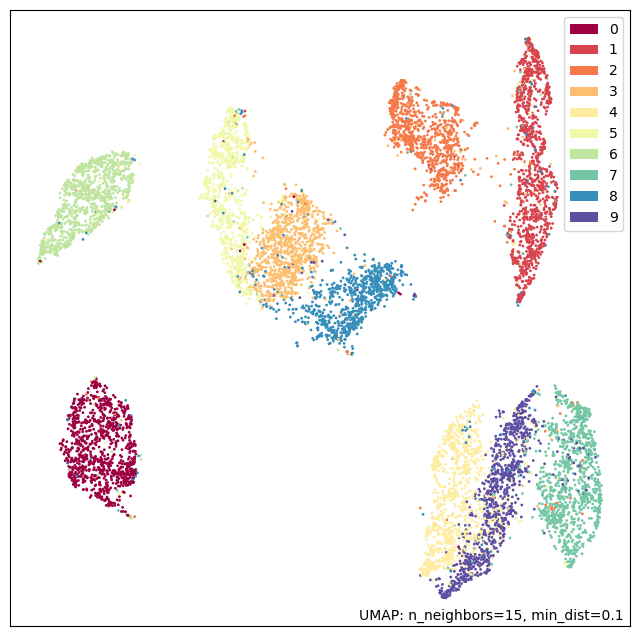

In [22]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [23]:
#Train fMNIST sequentially on top of MNIST

In [24]:
cloned_hypernetwork = tf.keras.models.clone_model(hypernetwork)

In [26]:
flosses = []  # Keep track of the losses over time.
ftrain_accs = []
ftest_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(ftrain_dataset):
        loss, train_acc = train_step(x, y, step, 1)
    
        # Logging.
        flosses.append(float(loss))
        ftrain_accs.append(train_acc)
        if step%1000 == 0:
            print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(ftest_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 1)
                ftest_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(flosses) / len(flosses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    acc_fn.reset_states()


Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 0.5971606969833374 Train Acc: tf.Tensor(1.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6368, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 0.751334904591539 Train Acc: tf.Tensor(0.64513546, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6502, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in

In [27]:
#savemodel
hypernetwork.save("WGNadafull_Mnist2Fmnist.h5")
with open('WGNadafull_Mnist2Fmnist_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('WGNadafull_Mnist2Fmnist_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('WGNadafull_Mnist2Fmnist_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

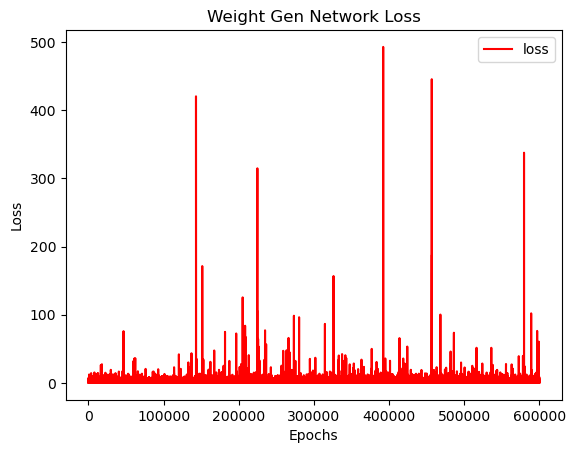

In [28]:
import matplotlib.pyplot as plt

plt.plot(flosses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


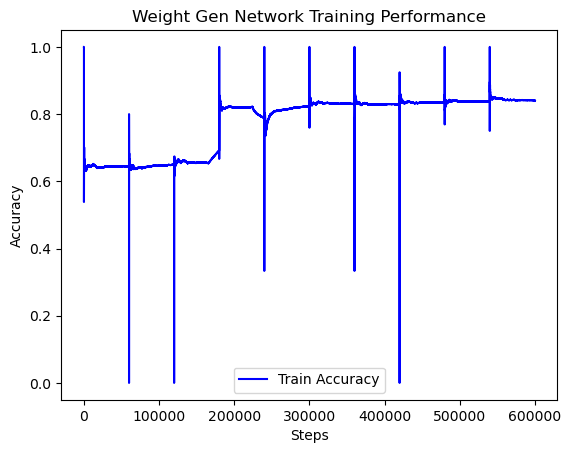

In [29]:
import matplotlib.pyplot as plt

plt.plot(ftrain_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

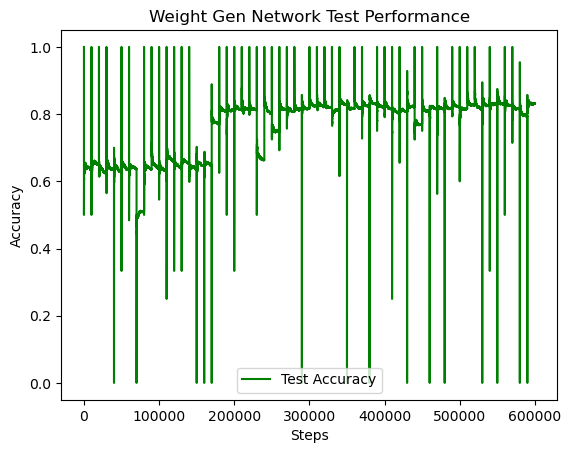

In [30]:
plt.plot(ftest_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
import gc
gc.collect()

95764

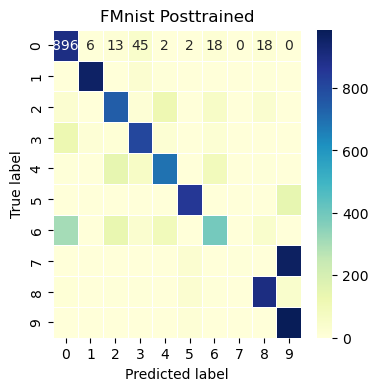

In [53]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Posttrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [54]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.7238 
precision =  [0.65211063 0.97261663 0.70789724 0.81496461 0.74038462 0.92034446
 0.66780822 1.         0.89395441 0.46207865] 
recall =  [0.896 0.959 0.744 0.806 0.693 0.855 0.39  0.006 0.902 0.987] 
f1 score =  [0.75484414 0.96576032 0.72549976 0.81045752 0.71590909 0.88646967
 0.49242424 0.01192843 0.89795918 0.62946429]

classwise metrics =  (array([0.65211063, 0.97261663, 0.70789724, 0.81496461, 0.74038462,
       0.92034446, 0.66780822, 1.        , 0.89395441, 0.46207865]), array([0.896, 0.959, 0.744, 0.806, 0.693, 0.855, 0.39 , 0.006, 0.902,
       0.987]), array([0.75484414, 0.96576032, 0.72549976, 0.81045752, 0.71590909,
       0.88646967, 0.49242424, 0.01192843, 0.89795918, 0.62946429]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Averging =  micro 

accuracy =  0.7238 
precision =  0.7238 
recall =  0.7238 
f1 score =  0.7238

classwise metrics =  (0.7238, 0.7238, 0.7238, None)

Averging =  macro 
accuracy =  0.

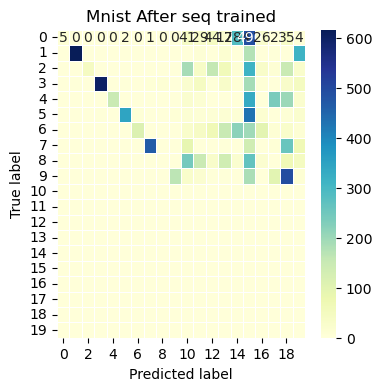

In [55]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist After seq trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.2505 
precision =  [1.         0.99194847 0.97826087 0.98846787 0.99333333 0.98290598
 0.95762712 0.98105263 0.         0.94857143 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
recall =  [0.00510204 0.54273128 0.04360465 0.59405941 0.15173116 0.3867713
 0.11795407 0.45330739 0.         0.16451933 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
f1 score =  [0.01015228 0.70159453 0.08348794 0.74211503 0.26325088 0.55510861
 0.21003717 0.62009315 0.         0.28040541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]

classwise metrics =  (array([1.        , 0.99194847, 0.97826087, 0.98846787, 0.99333333,
       0.98290598, 0.95762712, 0.98105263, 0.        , 0.94857143,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9

In [57]:
import gc
gc.collect()

15618

In [45]:
import umap
import umap.plot
sz=10000
imgs = fx_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = fy_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

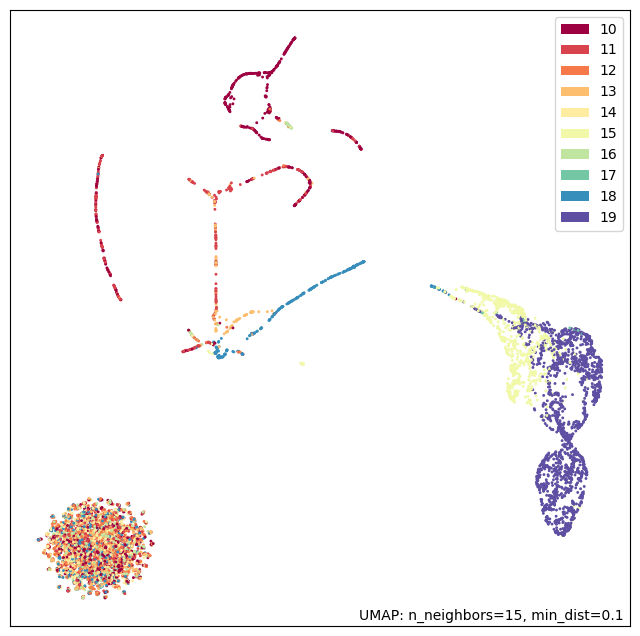

In [46]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

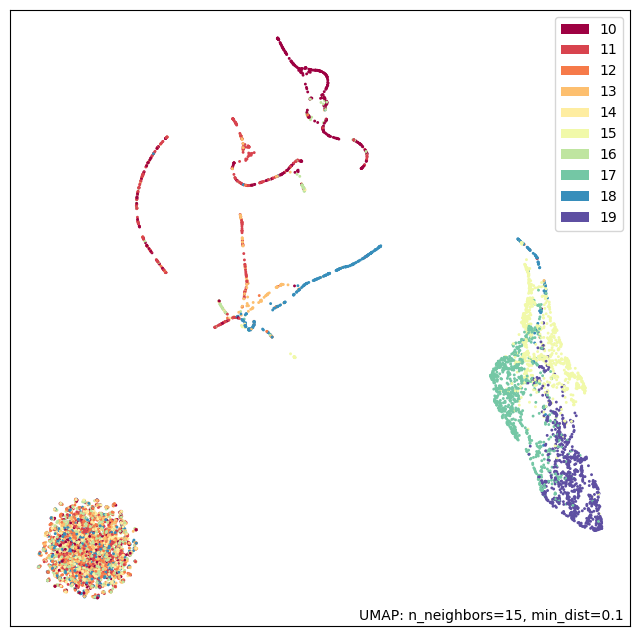

In [47]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(fy_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

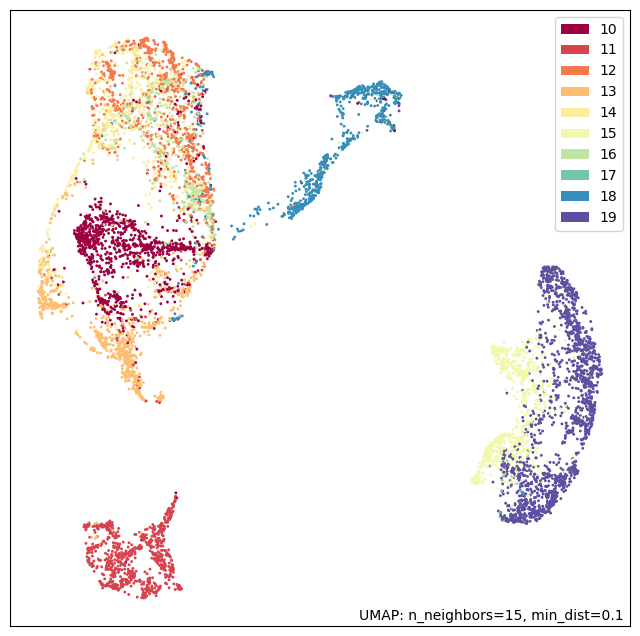

In [48]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

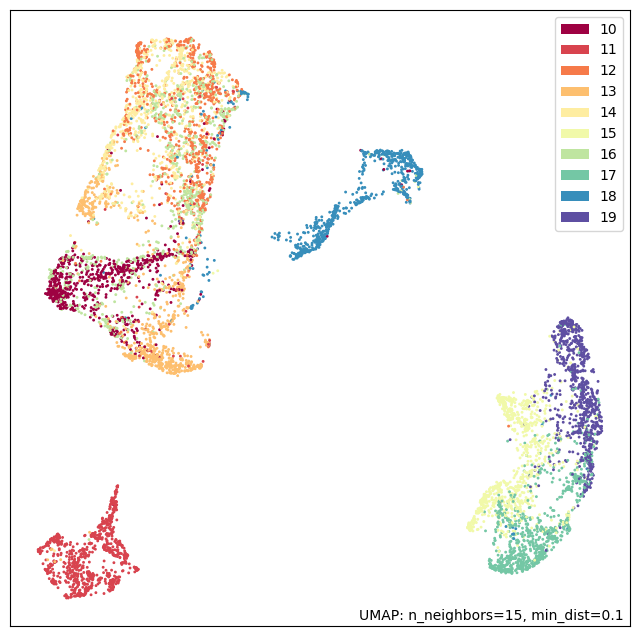

In [49]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels =  np.argmax(fy_train[:sz].reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

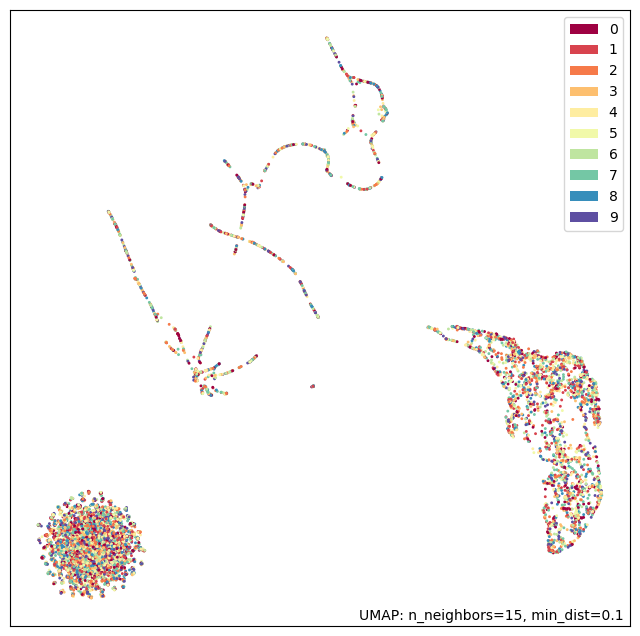

In [50]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

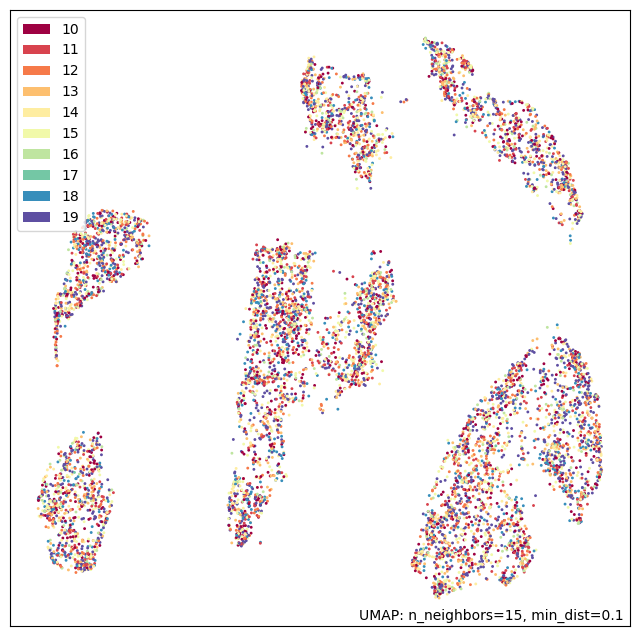

In [51]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [112]:
hypernetwork.load_weights("WGNadafull_Mnist2Fmnist.h5")

In [113]:
import gc
gc.collect()

102748

In [114]:
import gc
gc.collect()
import umap
import umap.plot
sz=10000
imgs = fx_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = fy_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

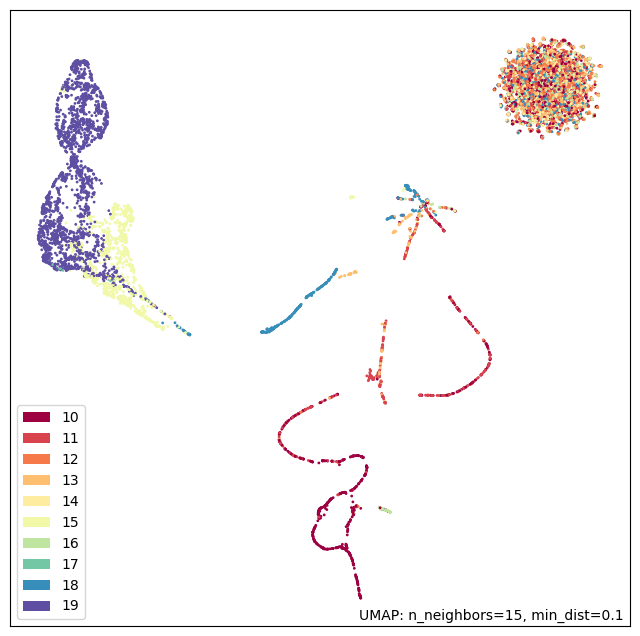

In [115]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

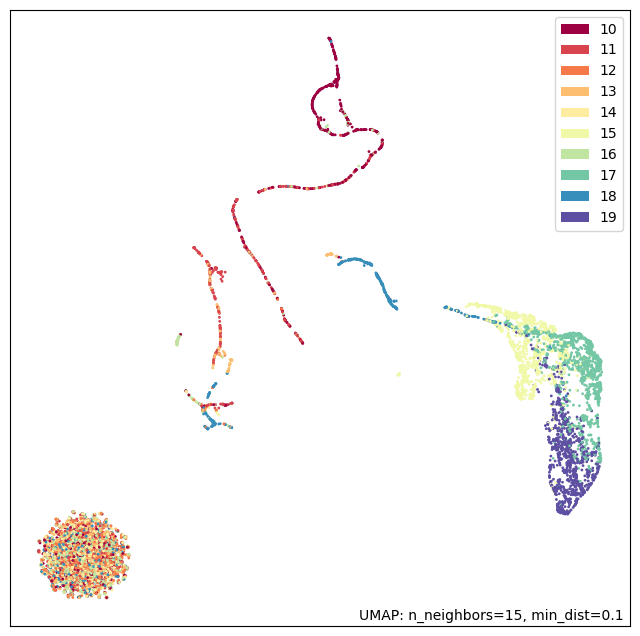

In [116]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(fy_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

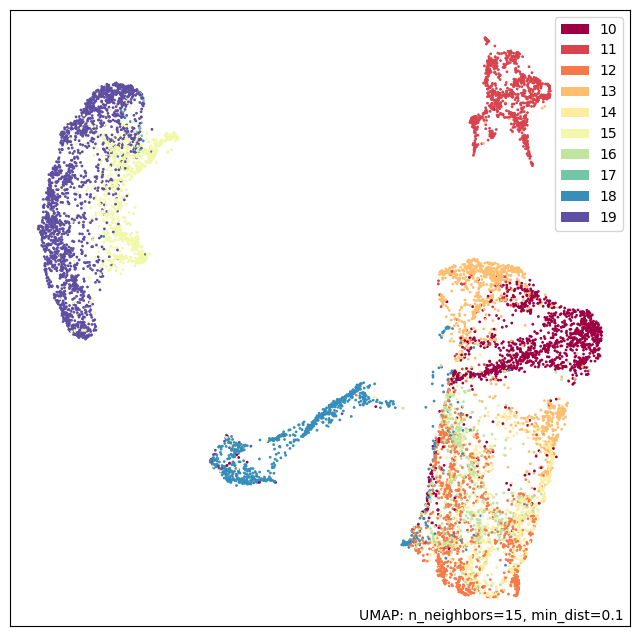

In [117]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

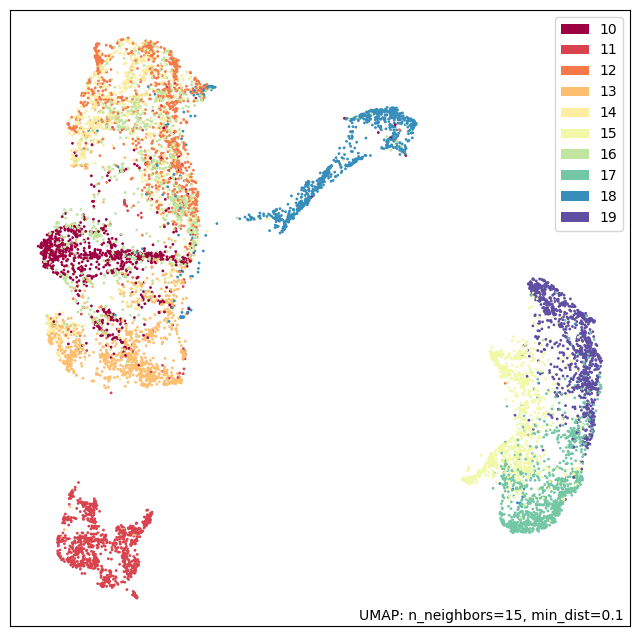

In [118]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels =  np.argmax(fy_train[:sz].reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [119]:
import gc
gc.collect()
import umap
import umap.plot
sz=10000
imgs = x_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = y_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

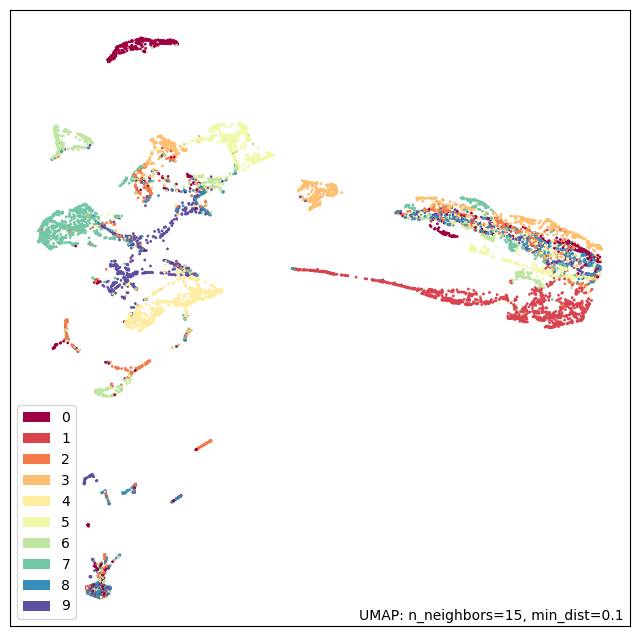

In [120]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

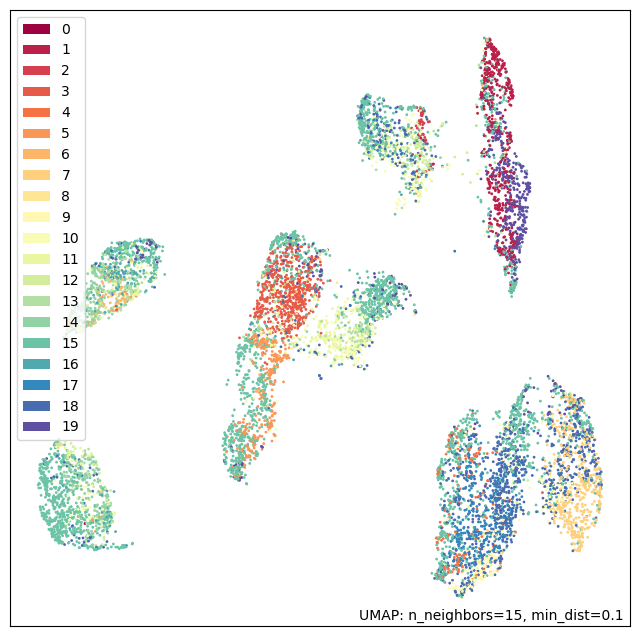

In [121]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

### mnist ada = 1 to fmnist with ada = 0.5

In [75]:
import gc
gc.collect()

277824

In [76]:
#init

weights_pred = hypernetwork(x_train.reshape(60000,1,784)[0])

hypernetwork.load_weights("WGNadafull_Mnist.h5")

# Reshape them to the expected shapes for w and b for the outer model.
# Layer 0 kernel.
start_index = 0
w0_shape = (input_dim, 256)
w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
w0 = tf.reshape(w0_coeffs, w0_shape)
start_index += np.prod(w0_shape)
# Layer 0 bias.
b0_shape = (256,)
b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
b0 = tf.reshape(b0_coeffs, b0_shape)
start_index += np.prod(b0_shape)
# Layer 1 kernel.
w1_shape = (256, classes)
w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
w1 = tf.reshape(w1_coeffs, w1_shape)
start_index += np.prod(w1_shape)
# Layer 1 bias.
b1_shape = (classes,)
b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
b1 = tf.reshape(b1_coeffs, b1_shape)
start_index += np.prod(b1_shape)

# Set the weight predictions as the weight variables on the outer model.
main_network.layers[0].kernel = w0
main_network.layers[0].bias = b0
main_network.layers[1].kernel = w1
main_network.layers[1].bias = b1

preds = main_network(x_train.reshape(60000,1,784)[0])


In [77]:
#Train fMNIST sequentially on top of MNIST

In [78]:
cloned_hypernetwork = tf.keras.models.clone_model(hypernetwork)

In [79]:
flosses = []  # Keep track of the losses over time.
ftrain_accs = []
ftest_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(ftrain_dataset):
        loss, train_acc = train_step(x, y, step, 0.5)
    
        # Logging.
        flosses.append(float(loss))
        ftrain_accs.append(train_acc)
        if step%1000 == 0:
            print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(ftest_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 0.5)
                ftest_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(flosses) / len(flosses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    acc_fn.reset_states()


Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 301.61181640625 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 2.1483517357166204 Train Acc: tf.Tensor(0.23367663, shape=(), dtype=float32) Test Acc: tf.Tensor(0.2794, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in prog

In [80]:
#savemodel
hypernetwork.save("WGNadafull_Mnist2Fmnistada05.h5")
with open('WGNadafull_Mnist2Fmnistada05_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('WGNadafull_Mnist2Fmnistada05_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('WGNadafull_Mnist2Fmnistada05_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

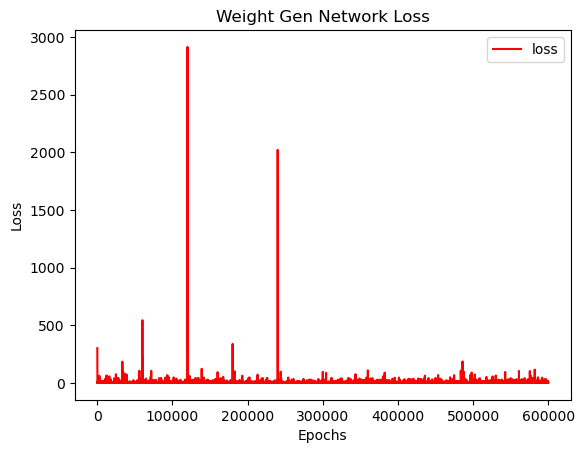

In [81]:
import matplotlib.pyplot as plt

plt.plot(flosses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


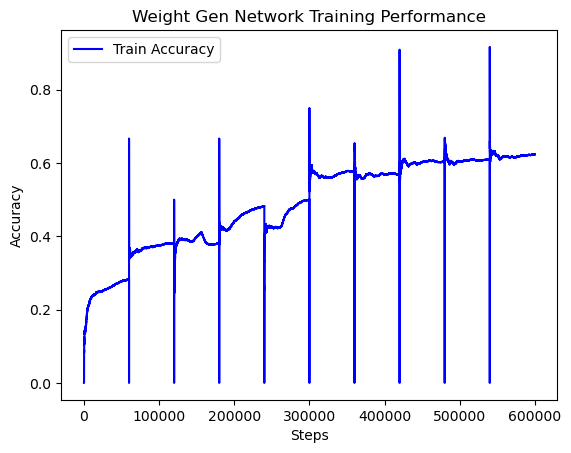

In [82]:
import matplotlib.pyplot as plt

plt.plot(ftrain_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

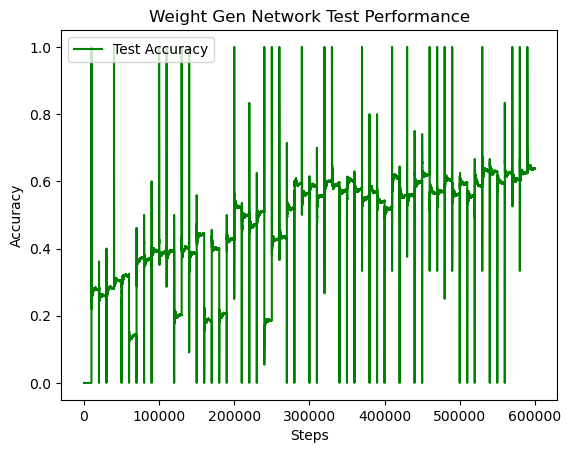

In [83]:
plt.plot(ftest_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [98]:
import gc
gc.collect()

273109

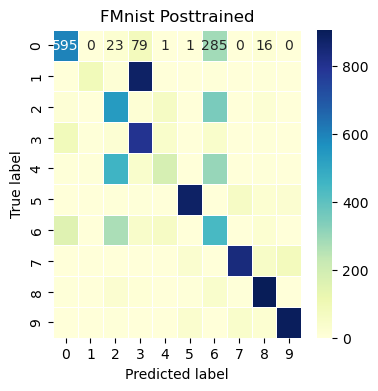

In [99]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt, 0.5)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Posttrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [100]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.6162 
precision =  [0.68469505 0.8440367  0.39311859 0.42650989 0.52136752 0.92616034
 0.30136986 0.88841658 0.83966636 0.8916501 ] 
recall =  [0.595 0.092 0.537 0.798 0.183 0.878 0.44  0.836 0.906 0.897] 
f1 score =  [0.63670412 0.16591524 0.45393068 0.55590387 0.27091044 0.90143737
 0.35772358 0.86141164 0.87157287 0.89431705]

classwise metrics =  (array([0.68469505, 0.8440367 , 0.39311859, 0.42650989, 0.52136752,
       0.92616034, 0.30136986, 0.88841658, 0.83966636, 0.8916501 ]), array([0.595, 0.092, 0.537, 0.798, 0.183, 0.878, 0.44 , 0.836, 0.906,
       0.897]), array([0.63670412, 0.16591524, 0.45393068, 0.55590387, 0.27091044,
       0.90143737, 0.35772358, 0.86141164, 0.87157287, 0.89431705]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Averging =  micro 

accuracy =  0.6162 
precision =  0.6162 
recall =  0.6162 
f1 score =  0.6162

classwise metrics =  (0.6162, 0.6162, 0.6162, None)

Averging =  macro 
accuracy =  0.

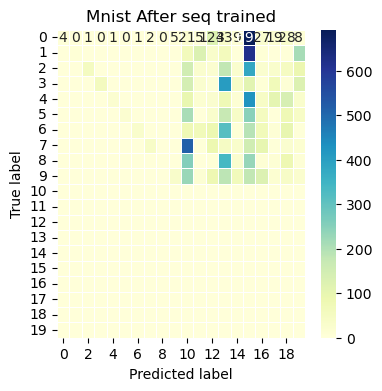

In [110]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt, 1)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist After seq trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [111]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.0265 
precision =  [1.         0.88888889 0.96428571 1.         0.68965517 0.95
 0.90322581 0.95238095 0.         0.80952381 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
recall =  [0.00408163 0.00704846 0.05232558 0.05742574 0.0203666  0.02130045
 0.02922756 0.03891051 0.         0.03369673 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
f1 score =  [0.00813008 0.01398601 0.09926471 0.10861423 0.03956479 0.04166667
 0.05662285 0.07476636 0.         0.06470029 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]

classwise metrics =  (array([1.        , 0.88888889, 0.96428571, 1.        , 0.68965517,
       0.95      , 0.90322581, 0.95238095, 0.        , 0.80952381,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.0

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9

In [103]:
import gc
gc.collect()

15618

In [91]:
import umap
import umap.plot
sz=10000
imgs = fx_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = fy_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

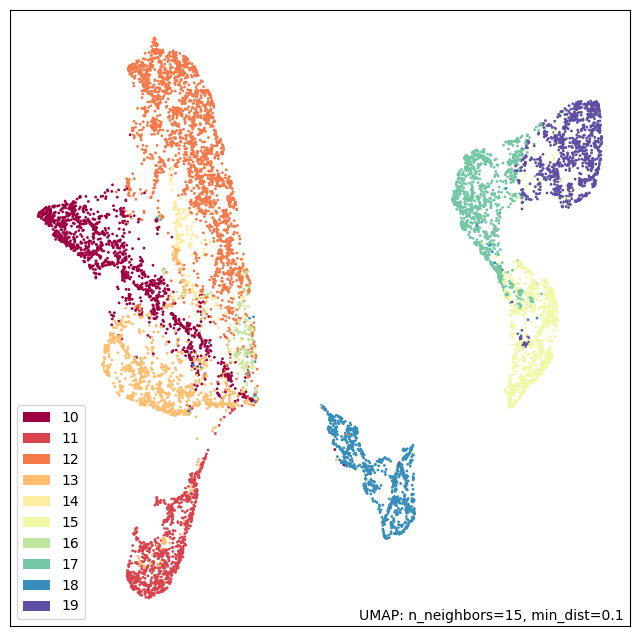

In [92]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

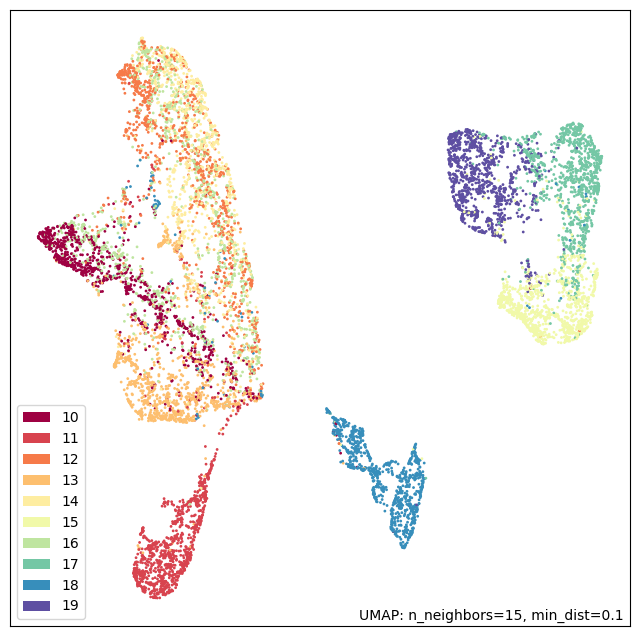

In [93]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(fy_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

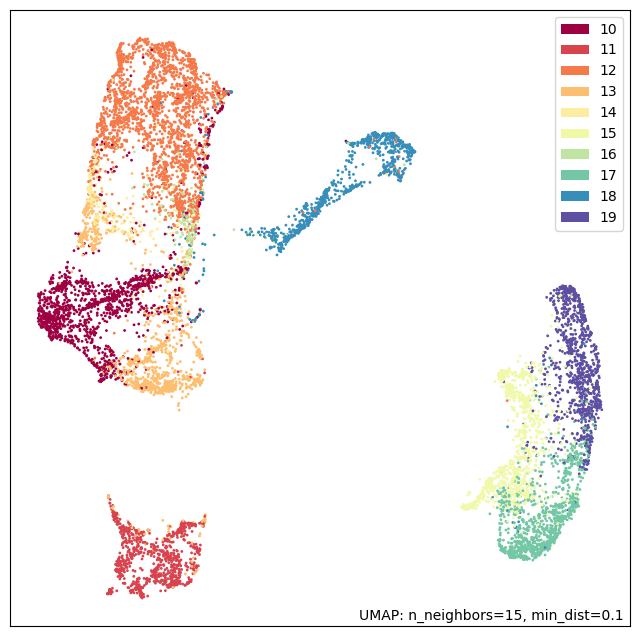

In [94]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

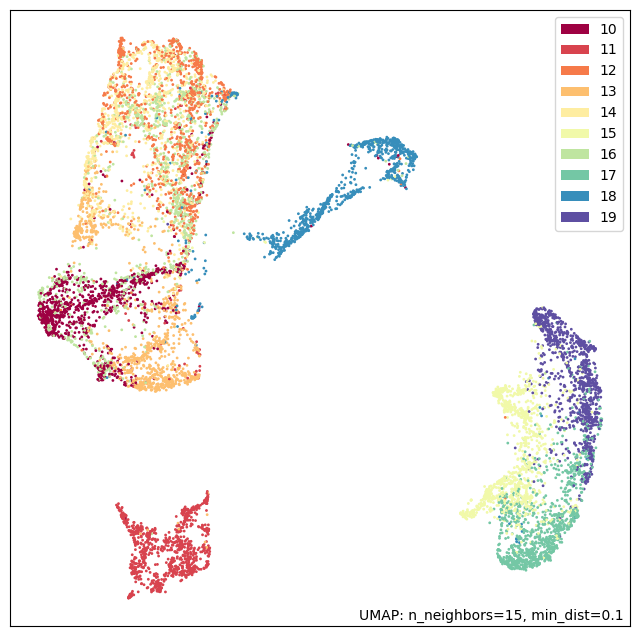

In [95]:
imgs = fx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels =  np.argmax(fy_train[:sz].reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [106]:
gc.collect()

1255

In [107]:
import umap
import umap.plot
sz=8000
imgs = x_train[:sz].reshape(sz, 1, 784).astype("float32") / 255
labels = y_train[:sz].reshape(sz, 1, 20)
weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

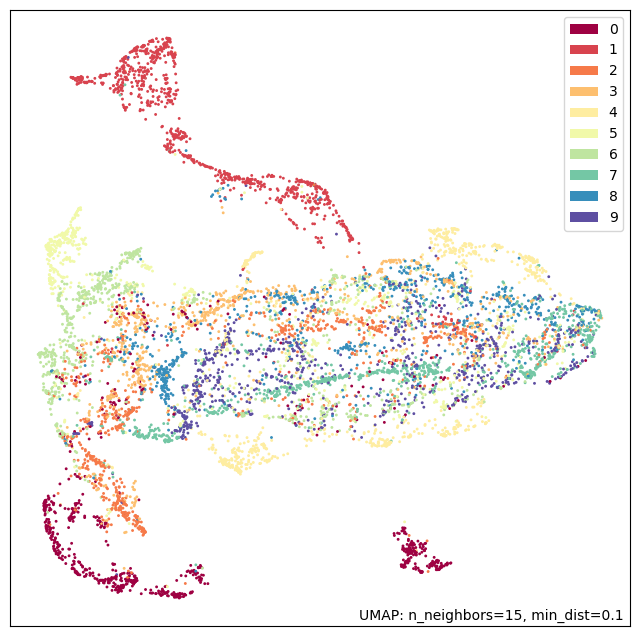

In [108]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

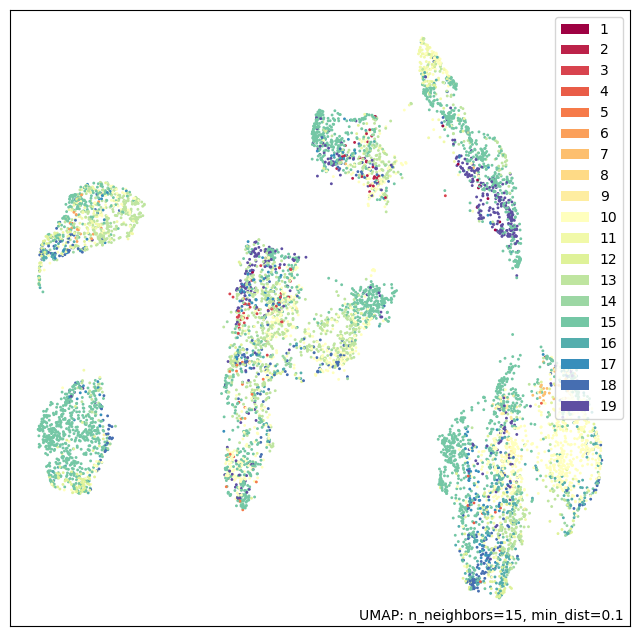

In [109]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

# BothTasksTogether [Extended]

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-05-16 14:56:34.323365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-16 14:56:35.432545: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-16 14:56:35.433129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-16 14:56:35.490009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-16 14:56:35.490071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-16 14:56:35.493333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-

In [2]:
import tensorflow as tf
from tensorflow import keras 

In [3]:
import numpy as np

input_dim = 784
classes = 20

main_network = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 256 + classes) + (256 * input_dim + 256)

# hypernetwork that generates the weights of the `main_network.
hypernetwork = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

2024-05-16 14:56:40.522828: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 14:56:40.525182: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-16 14:56:40.526805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-16 14:56:40.526865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-16 14:56:40.526934: I tensorflow/stream_executor/platform/de

In [4]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
import numpy as np
a = np.zeros((len(y_train),1))
b = np.zeros((len(y_test),1))

for i in range(10):
    y_train = np.hstack((y_train, a))
    y_test = np.hstack((y_test, b))

In [6]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(fx_train, fy_train), (fx_test, fy_test) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
fx_train = fx_train.astype("float32") / 255
fx_test = fx_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
fx_train = np.expand_dims(fx_train, -1)
fx_test = np.expand_dims(fx_test, -1)
print("x_train shape:", fx_train.shape)
print(fx_train.shape[0], "train samples")
print(fx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
fy_train = keras.utils.to_categorical(fy_train, num_classes)
fy_test = keras.utils.to_categorical(fy_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
import numpy as np
a = np.zeros((len(fy_train),1))
b = np.zeros((len(fy_test),1))

for i in range(10):
    fy_train = np.hstack((a,fy_train))
    fy_test = np.hstack((b,fy_test))

In [8]:
abx_train = np.concatenate((x_train, fx_train), axis=0)
aby_train = np.concatenate((y_train, fy_train), axis=0)
abx_test = np.concatenate((x_test, fx_test), axis=0)
aby_test = np.concatenate((y_test, fy_test), axis=0)

In [9]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD()

#@tf.function
def train_step(x, y, step, ada = 1):
    with tf.GradientTape() as tape:
        if step == 0:
            weights_init = tf.random.uniform((1,num_weights_to_generate))
            # Reshape them to the expected shapes for w and b for the outer model.
            # Layer 0 kernel.
            start_index = 0
            w0_shape = (input_dim, 256)
            w0_coeffs = weights_init[:, start_index : start_index + np.prod(w0_shape)]
            w0 = tf.reshape(w0_coeffs, w0_shape)
            start_index += np.prod(w0_shape)
            # Layer 0 bias.
            b0_shape = (256,)
            b0_coeffs = weights_init[:, start_index : start_index + np.prod(b0_shape)]
            b0 = tf.reshape(b0_coeffs, b0_shape)
            start_index += np.prod(b0_shape)
            # Layer 1 kernel.
            w1_shape = (256, classes)
            w1_coeffs = weights_init[:, start_index : start_index + np.prod(w1_shape)]
            w1 = tf.reshape(w1_coeffs, w1_shape)
            start_index += np.prod(w1_shape)
            # Layer 1 bias.
            b1_shape = (classes,)
            b1_coeffs = weights_init[:, start_index : start_index + np.prod(b1_shape)]
            b1 = tf.reshape(b1_coeffs, b1_shape)
            start_index += np.prod(b1_shape)

            main_network.layers[0].kernel = w0
            main_network.layers[0].bias = b0
            main_network.layers[1].kernel = w1
            main_network.layers[1].bias = b1
        
        # Predict weights for the outer model.
        weights_pred = hypernetwork(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 256)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (256,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (256, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        
        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
        main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
        main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
        main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1
        
        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, hypernetwork.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernetwork.trainable_weights))
    return loss, train_acc



In [10]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

#@tf.function
def test_step(x, y, ada = 1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_train.reshape(120000, 784).astype("float32") / 255, aby_train.reshape(120000, 20))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_test.reshape(20000, 784).astype("float32") / 255, aby_test.reshape(20000, 20))
)

train_dataset = train_dataset.shuffle(buffer_size=120000).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=120000).batch(1)

In [12]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        loss, train_acc = train_step(x, y, step, 1)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%1000 == 0:
                print("Epochs:", i, "Step in progress:", step)
        if step % 10000 == 0:
            #evaluate on testdata
            for tstep, (xt, yt) in enumerate(test_dataset):
                test_loss, test_acc, preds = test_step(xt, yt, 1)
                test_accs.append(test_acc)
            tstacc_fn.reset_states()
            
            print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)
    
    acc_fn.reset_states()

2024-05-16 14:57:16.380245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epochs: 0 Step in progress: 0
Epochs: 0 Step: 0 Train Loss: 2.9955942630767822 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0505, shape=(), dtype=float32)
Epochs: 0 Step in progress: 1000
Epochs: 0 Step in progress: 2000
Epochs: 0 Step in progress: 3000
Epochs: 0 Step in progress: 4000
Epochs: 0 Step in progress: 5000
Epochs: 0 Step in progress: 6000
Epochs: 0 Step in progress: 7000
Epochs: 0 Step in progress: 8000
Epochs: 0 Step in progress: 9000
Epochs: 0 Step in progress: 10000
Epochs: 0 Step: 10000 Train Loss: 2.997162442554916 Train Acc: tf.Tensor(0.052994702, shape=(), dtype=float32) Test Acc: tf.Tensor(0.05, shape=(), dtype=float32)
Epochs: 0 Step in progress: 11000
Epochs: 0 Step in progress: 12000
Epochs: 0 Step in progress: 13000
Epochs: 0 Step in progress: 14000
Epochs: 0 Step in progress: 15000
Epochs: 0 Step in progress: 16000
Epochs: 0 Step in progress: 17000
Epochs: 0 Step in progress: 18000
Epochs: 0 Step in progress: 19000
Epochs: 0 Step in 

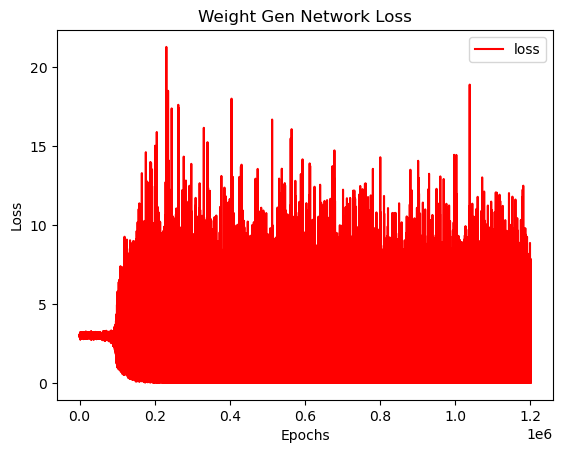

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


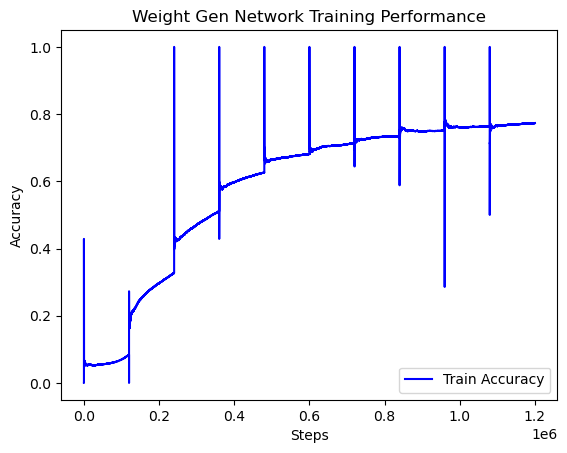

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

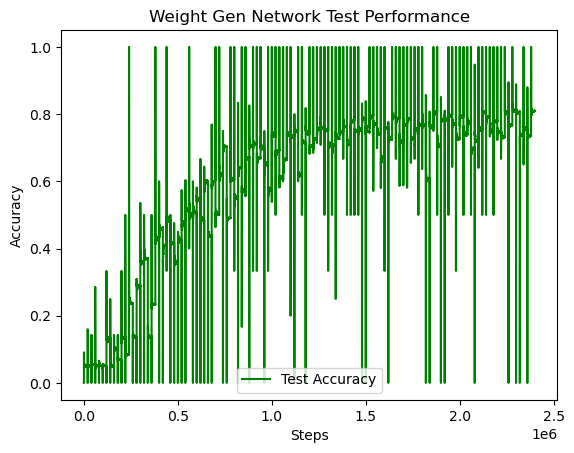

In [15]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
#savemodel
hypernetwork.save("WGNadafull_Bothnist.h5")
with open('WGNadafull_Bothnist_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('WGNadafull_Bothnist_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('WGNadafull_Bothnist_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))


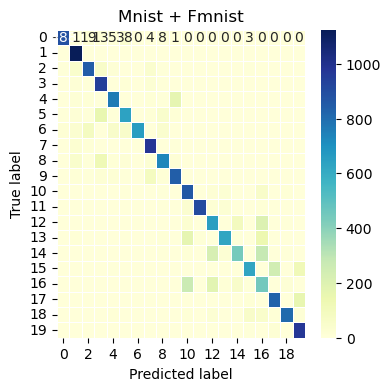

In [17]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist + Fmnist')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

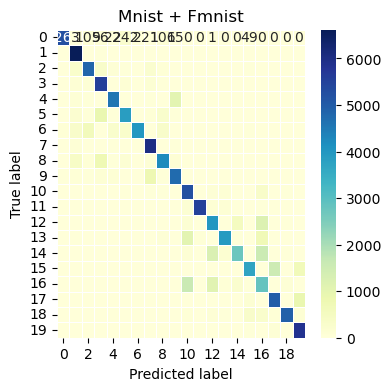

In [18]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = train_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist + Fmnist')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
"""
weights_pred = hypernetwork(x_train.reshape(60000,1,784)[0])

hypernetwork.load_weights("WGNadafull_MnFmnist.h5")

# Reshape them to the expected shapes for w and b for the outer model.
# Layer 0 kernel.
start_index = 0
w0_shape = (input_dim, 256)
w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
w0 = tf.reshape(w0_coeffs, w0_shape)
start_index += np.prod(w0_shape)
# Layer 0 bias.
b0_shape = (256,)
b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
b0 = tf.reshape(b0_coeffs, b0_shape)
start_index += np.prod(b0_shape)
# Layer 1 kernel.
w1_shape = (256, classes)
w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
w1 = tf.reshape(w1_coeffs, w1_shape)
start_index += np.prod(w1_shape)
# Layer 1 bias.
b1_shape = (classes,)
b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
b1 = tf.reshape(b1_coeffs, b1_shape)
start_index += np.prod(b1_shape)

# Set the weight predictions as the weight variables on the outer model.
main_network.layers[0].kernel = w0
main_network.layers[0].bias = b0
main_network.layers[1].kernel = w1
main_network.layers[1].bias = b1

preds = main_network(x_train.reshape(60000,1,784)[0])
"""


In [19]:
from tensorflow.keras import backend as K

# here X is param 1 (input) and the function returns output from layers
# Inference on the outer model.
get_layer_output = K.function(
  [main_network.layers[0].input], # param 1 will be treated as layer[0].output
  [main_network.layers[1].output]) 

eval_fn = tf.keras.metrics.CategoricalAccuracy()

def eval_step(x, y, ada=1):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    lyr = get_layer_output(x)
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    eval_fn.update_state(y, preds)    
    evalacc = eval_fn.result()
 
    return evalacc, lyr, preds, weights_pred

In [20]:
import umap
import umap.plot
sz=10000

imgs = abx_train[55000:55000+sz].reshape(sz, 1, 784).astype("float32") / 255
labels = aby_train[55000:55000+sz].reshape(sz, 1, 20)

weight_preds = []
lyrpreds = []
preds = []
eaccs = []

for i in range(len(imgs)):
    eacc, lyrpred, pred, weight_pred = eval_step(imgs[i], labels[i])
    weight_preds.append(weight_pred)
    lyrpreds.append(lyrpred)
    preds.append(pred)
    eaccs.append(eacc)
eval_fn.reset_states()   

<Axes: >

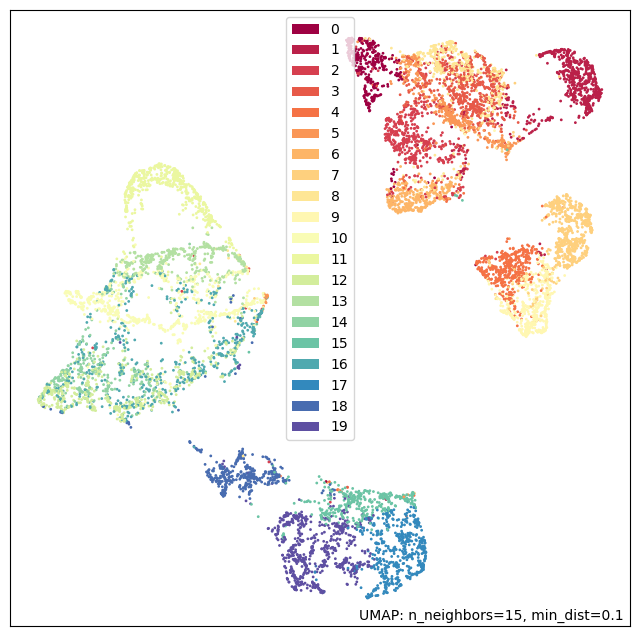

In [21]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

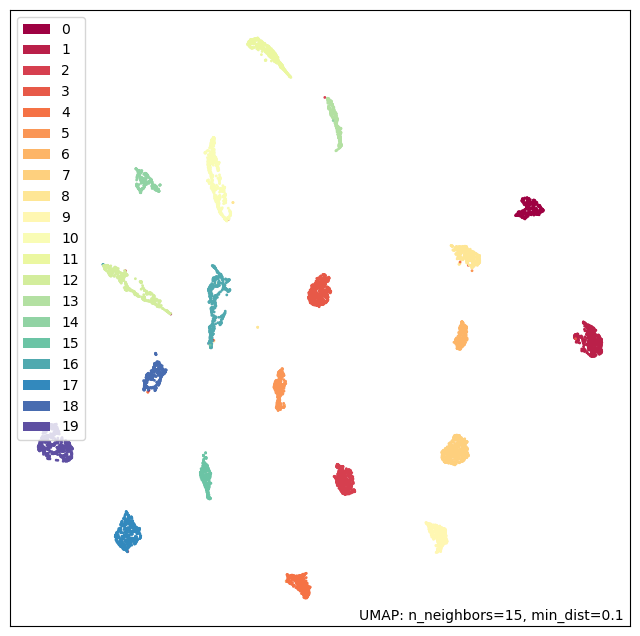

In [22]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

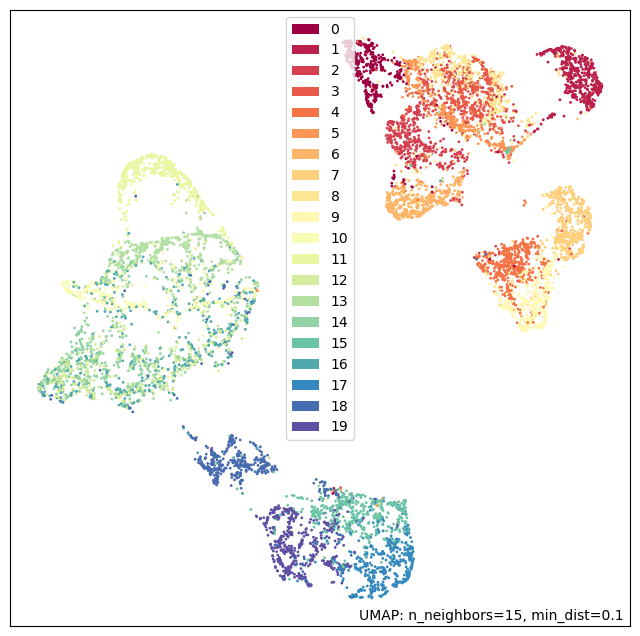

In [23]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[55000:55000+sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

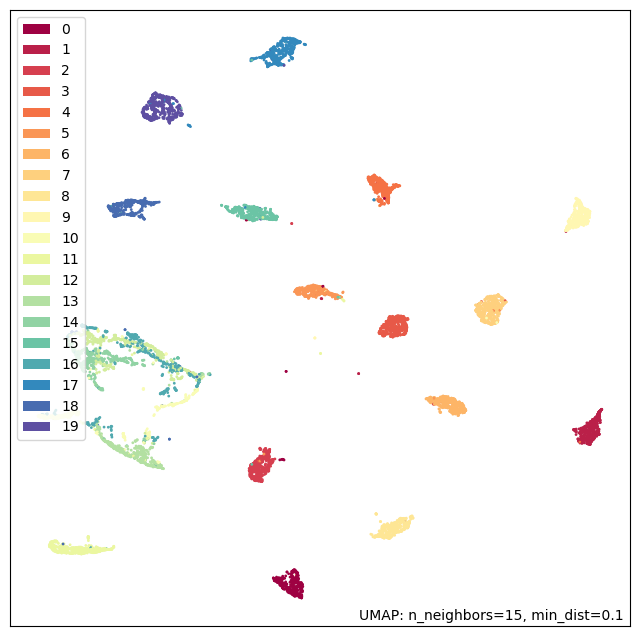

In [24]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[55000:55000+sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

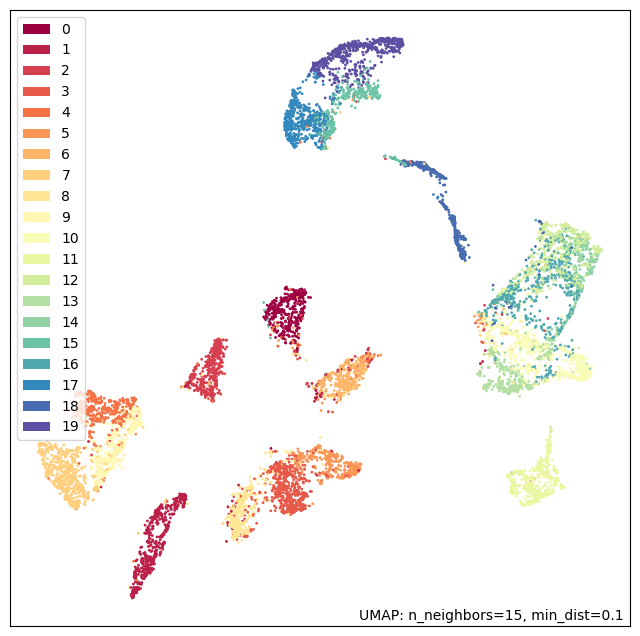

In [25]:
imgs = abx_train[55000:55000+sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

## 2. Overlapping labels sequential learning

In [1]:
import tensorflow as tf
from tensorflow import keras 

2022-08-05 03:33:03.191953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np

input_dim = 784
classes = 10

main_network = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 256 + classes) + (256 * input_dim + 256)

# hypernetwork that generates the weights of the `main_network.
hypernetwork = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.sigmoid),
    ]
)

2022-08-05 03:33:37.322280: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 03:33:37.323600: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-05 03:33:37.430394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-05 03:33:37.431328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-05 03:33:37.431356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-05 03

In [3]:
import numpy as np

# Prepare dataset 1.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test)
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(1)




In [4]:
# Prepare dataset 2.
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()

# convert class vectors to binary class matrices
fy_train = keras.utils.to_categorical(fy_train, 10)
fy_test = keras.utils.to_categorical(fy_test, 10)


ftrain_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_train.reshape(60000, 784).astype("float32") / 255, fy_train)
)
ftest_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_test.reshape(10000, 784).astype("float32") / 255, fy_test)
)

ftrain_dataset = ftrain_dataset.shuffle(buffer_size=1024).batch(1)
ftest_dataset = ftest_dataset.shuffle(buffer_size=1024).batch(1)

In [5]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = hypernetwork(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 256)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (256,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (256, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = w0
        main_network.layers[0].bias = b0
        main_network.layers[1].kernel = w1
        main_network.layers[1].bias = b1

        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, hypernetwork.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernetwork.trainable_weights))
    return loss, train_acc


In [6]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def test_step(x, y):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = w0
    main_network.layers[0].bias = b0
    main_network.layers[1].kernel = w1
    main_network.layers[1].bias = b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds

In [7]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)

for step, (x, y) in enumerate(train_dataset):
    loss, train_acc = train_step(x, y)

    # Logging.
    losses.append(float(loss))
    train_accs.append(train_acc)
    if step % 100 == 0:
        #evaluate on testdata
        for tstep, (xt, yt) in enumerate(test_dataset):
            test_loss, test_acc, _ = test_step(xt, yt)
            test_accs.append(test_acc)
        tstacc_fn.reset_states()
        
        print("Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

    # Stop after 1000 steps.
    if step >= 10000:
        break
acc_fn.reset_states()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-05 03:34:23.037941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-05 03:34:23.057369: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2022-08-05 03:34:23.105937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step: 0 Train Loss: 9.357826232910156 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0958, shape=(), dtype=float32)
Step: 100 Train Loss: 14.674765372812503 Train Acc: tf.Tensor(0.31683168, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5246, shape=(), dtype=float32)
Step: 200 Train Loss: 13.247085775188324 Train Acc: tf.Tensor(0.3681592, shape=(), dtype=float32) Test Acc

Step: 4900 Train Loss: 3.231904209721677 Train Acc: tf.Tensor(0.7867782, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8288, shape=(), dtype=float32)
Step: 5000 Train Loss: 3.2385924386559823 Train Acc: tf.Tensor(0.78724253, shape=(), dtype=float32) Test Acc: tf.Tensor(0.7894, shape=(), dtype=float32)
Step: 5100 Train Loss: 3.210409771383811 Train Acc: tf.Tensor(0.78808075, shape=(), dtype=float32) Test Acc: tf.Tensor(0.7861, shape=(), dtype=float32)
Step: 5200 Train Loss: 3.1890167392565965 Train Acc: tf.Tensor(0.7885022, shape=(), dtype=float32) Test Acc: tf.Tensor(0.831, shape=(), dtype=float32)
Step: 5300 Train Loss: 3.1577673809499265 Train Acc: tf.Tensor(0.79060555, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8487, shape=(), dtype=float32)
Step: 5400 Train Loss: 3.1228325993658 Train Acc: tf.Tensor(0.79244584, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8377, shape=(), dtype=float32)
Step: 5500 Train Loss: 3.1190082406681077 Train Acc: tf.Tensor(0.7936739, shape=(), dtype=

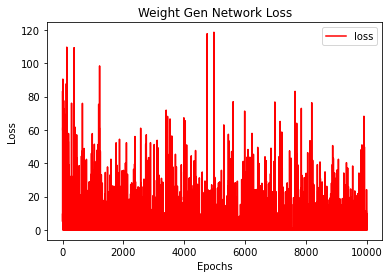

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


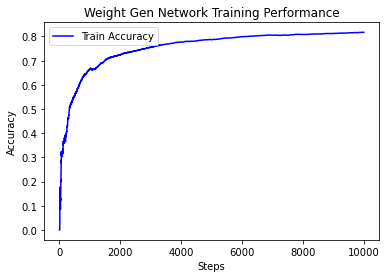

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

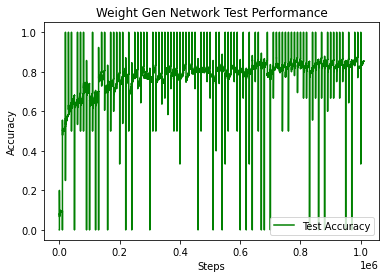

In [10]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

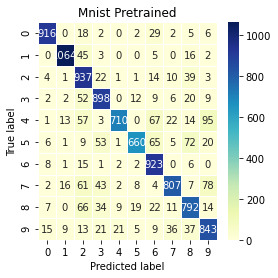

In [11]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

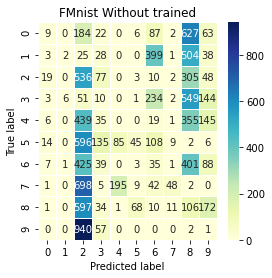

In [12]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Without trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [13]:
#Train fMNIST sequentially on top of MNIST

In [14]:
cloned_hypernetwork = tf.keras.models.clone_model(hypernetwork)

In [15]:
flosses = []  # Keep track of the losses over time.
ftrain_accs = []
ftest_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)

for step, (x, y) in enumerate(ftrain_dataset):
    loss, train_acc = train_step(x, y)

    # Logging.
    flosses.append(float(loss))
    ftrain_accs.append(train_acc)
    if step % 100 == 0:
        #evaluate on testdata
        for tstep, (xt, yt) in enumerate(ftest_dataset):
            test_loss, test_acc, _ = test_step(xt, yt)
            ftest_accs.append(test_acc)
        tstacc_fn.reset_states()
        
        print("Step:", step, "Train Loss:", sum(flosses) / len(flosses), "Train Acc:", train_acc, "Test Acc:", test_acc)

    # Stop after 1000 steps.
    if step >= 10000:
        break
acc_fn.reset_states()

Step: 0 Train Loss: 0.0 Train Acc: tf.Tensor(1.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.0794, shape=(), dtype=float32)
Step: 100 Train Loss: 30.81684608551797 Train Acc: tf.Tensor(0.2970297, shape=(), dtype=float32) Test Acc: tf.Tensor(0.3047, shape=(), dtype=float32)
Step: 200 Train Loss: 18.772343352560846 Train Acc: tf.Tensor(0.3631841, shape=(), dtype=float32) Test Acc: tf.Tensor(0.4588, shape=(), dtype=float32)
Step: 300 Train Loss: 14.671359034663807 Train Acc: tf.Tensor(0.38870433, shape=(), dtype=float32) Test Acc: tf.Tensor(0.4914, shape=(), dtype=float32)
Step: 400 Train Loss: 12.726189103359607 Train Acc: tf.Tensor(0.41396508, shape=(), dtype=float32) Test Acc: tf.Tensor(0.4773, shape=(), dtype=float32)
Step: 500 Train Loss: 11.314010483309701 Train Acc: tf.Tensor(0.4231537, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5083, shape=(), dtype=float32)
Step: 600 Train Loss: 10.22018842346982 Train Acc: tf.Tensor(0.43926787, shape=(), dtype=float32) Test Acc: tf.Tenso

Step: 5500 Train Loss: 3.6698488187268983 Train Acc: tf.Tensor(0.5657153, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5726, shape=(), dtype=float32)
Step: 5600 Train Loss: 3.628978301945187 Train Acc: tf.Tensor(0.56579185, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6226, shape=(), dtype=float32)
Step: 5700 Train Loss: 3.6160466943973693 Train Acc: tf.Tensor(0.5669181, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5906, shape=(), dtype=float32)
Step: 5800 Train Loss: 3.5857666340292282 Train Acc: tf.Tensor(0.5690398, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6, shape=(), dtype=float32)
Step: 5900 Train Loss: 3.556328364609246 Train Acc: tf.Tensor(0.57024235, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6369, shape=(), dtype=float32)
Step: 6000 Train Loss: 3.52451835052904 Train Acc: tf.Tensor(0.5712381, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5887, shape=(), dtype=float32)
Step: 6100 Train Loss: 3.514912602522656 Train Acc: tf.Tensor(0.572693, shape=(), dtype=float

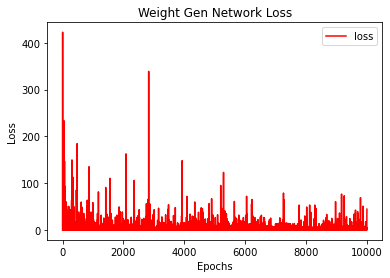

In [16]:
import matplotlib.pyplot as plt

plt.plot(flosses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


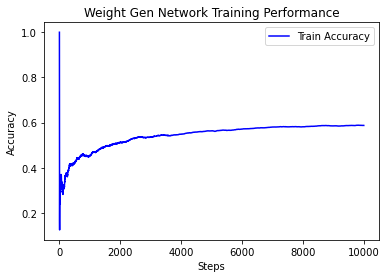

In [17]:
import matplotlib.pyplot as plt

plt.plot(ftrain_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

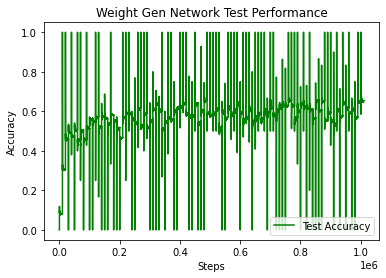

In [18]:
plt.plot(ftest_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

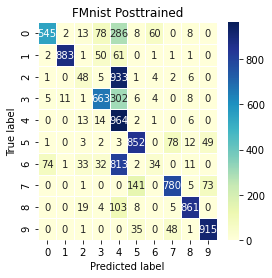

In [19]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Posttrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

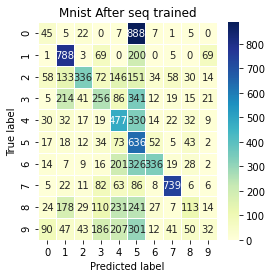

In [20]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist After seq trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:

"""

## 3. Overlapping labels sequential learning SWAPPED

In [1]:
import tensorflow as tf
from tensorflow import keras 

2022-08-24 05:32:32.768801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np

input_dim = 784
classes = 10

main_network = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 256 + classes) + (256 * input_dim + 256)

# hypernetwork that generates the weights of the `main_network.
hypernetwork = keras.Sequential(
    [
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.sigmoid),
    ]
)

2022-08-24 05:32:36.201911: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-24 05:32:36.203107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-24 05:32:36.284013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-24 05:32:36.284701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-24 05:32:36.284721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-24 05

In [3]:
import numpy as np

# Prepare dataset 1.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test)
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(1)




In [4]:
# Prepare dataset 2.
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.mnist.load_data()

# convert class vectors to binary class matrices
fy_train = keras.utils.to_categorical(fy_train, 10)
fy_test = keras.utils.to_categorical(fy_test, 10)


ftrain_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_train.reshape(60000, 784).astype("float32") / 255, fy_train)
)
ftest_dataset = tf.data.Dataset.from_tensor_slices(
    (fx_test.reshape(10000, 784).astype("float32") / 255, fy_test)
)

ftrain_dataset = ftrain_dataset.shuffle(buffer_size=1024).batch(1)
ftest_dataset = ftest_dataset.shuffle(buffer_size=1024).batch(1)

In [5]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = hypernetwork(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 256)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (256,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (256, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = w0
        main_network.layers[0].bias = b0
        main_network.layers[1].kernel = w1
        main_network.layers[1].bias = b1

        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, hypernetwork.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernetwork.trainable_weights))
    return loss, train_acc


In [6]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def test_step(x, y):
    # Predict weights for the outer model.
    weights_pred = hypernetwork(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 256)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (256,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (256, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = w0
    main_network.layers[0].bias = b0
    main_network.layers[1].kernel = w1
    main_network.layers[1].bias = b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds

In [7]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)

for step, (x, y) in enumerate(train_dataset):
    loss, train_acc = train_step(x, y)

    # Logging.
    losses.append(float(loss))
    train_accs.append(train_acc)
    if step % 100 == 0:
        #evaluate on testdata
        for tstep, (xt, yt) in enumerate(test_dataset):
            test_loss, test_acc, _ = test_step(xt, yt)
            test_accs.append(test_acc)
        tstacc_fn.reset_states()
        
        print("Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

    # Stop after 1000 steps.
    if step >= 10000:
        break
acc_fn.reset_states()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-24 05:33:22.211468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-24 05:33:22.233189: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2022-08-24 05:33:22.280743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step: 0 Train Loss: 21.443359375 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.1, shape=(), dtype=float32)
Step: 100 Train Loss: 40.612035514043626 Train Acc: tf.Tensor(0.36633664, shape=(), dtype=float32) Test Acc: tf.Tensor(0.4831, shape=(), dtype=float32)
Step: 200 Train Loss: 32.14828933555814 Train Acc: tf.Tensor(0.44278607, shape=(), dtype=float32) Test Acc: tf.Ten

Step: 4900 Train Loss: 4.854546835586725 Train Acc: tf.Tensor(0.6323199, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6367, shape=(), dtype=float32)
Step: 5000 Train Loss: 4.803453359865043 Train Acc: tf.Tensor(0.6330734, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6619, shape=(), dtype=float32)
Step: 5100 Train Loss: 4.751984011881133 Train Acc: tf.Tensor(0.63360125, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6112, shape=(), dtype=float32)
Step: 5200 Train Loss: 4.747785769445338 Train Acc: tf.Tensor(0.63333976, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6226, shape=(), dtype=float32)
Step: 5300 Train Loss: 4.704679398629086 Train Acc: tf.Tensor(0.6334654, shape=(), dtype=float32) Test Acc: tf.Tensor(0.656, shape=(), dtype=float32)
Step: 5400 Train Loss: 4.683021633894232 Train Acc: tf.Tensor(0.6321052, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6086, shape=(), dtype=float32)
Step: 5500 Train Loss: 4.65146408791647 Train Acc: tf.Tensor(0.631158, shape=(), dtype=float3

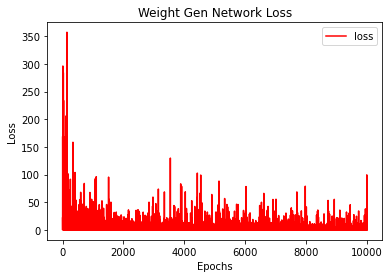

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


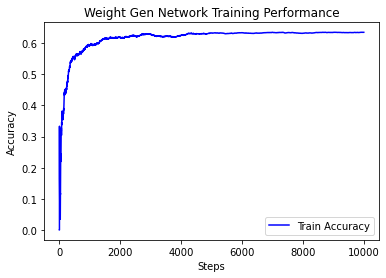

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

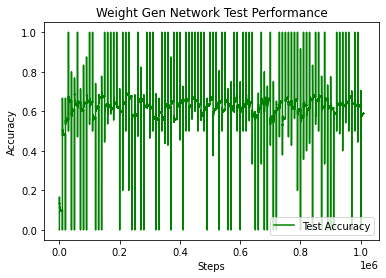

In [10]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

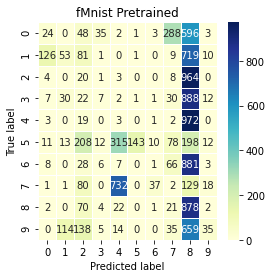

In [21]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('fMnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

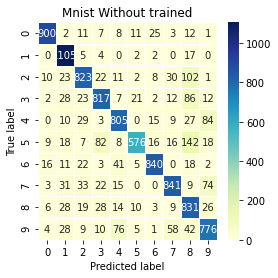

In [22]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Without trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [13]:
#Train MNIST sequentially on top of fMNIST

In [14]:
cloned_hypernetwork = tf.keras.models.clone_model(hypernetwork)

In [15]:
flosses = []  # Keep track of the losses over time.
ftrain_accs = []
ftest_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)

for step, (x, y) in enumerate(ftrain_dataset):
    loss, train_acc = train_step(x, y)

    # Logging.
    flosses.append(float(loss))
    ftrain_accs.append(train_acc)
    if step % 100 == 0:
        #evaluate on testdata
        for tstep, (xt, yt) in enumerate(ftest_dataset):
            test_loss, test_acc, _ = test_step(xt, yt)
            ftest_accs.append(test_acc)
        tstacc_fn.reset_states()
        
        print("Step:", step, "Train Loss:", sum(flosses) / len(flosses), "Train Acc:", train_acc, "Test Acc:", test_acc)

    # Stop after 1000 steps.
    if step >= 10000:
        break
acc_fn.reset_states()

Step: 0 Train Loss: 52.04296875 Train Acc: tf.Tensor(0.0, shape=(), dtype=float32) Test Acc: tf.Tensor(0.1116, shape=(), dtype=float32)
Step: 100 Train Loss: 11.386454905310961 Train Acc: tf.Tensor(0.28712872, shape=(), dtype=float32) Test Acc: tf.Tensor(0.4177, shape=(), dtype=float32)
Step: 200 Train Loss: 8.100746471002992 Train Acc: tf.Tensor(0.4079602, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5377, shape=(), dtype=float32)
Step: 300 Train Loss: 7.046603946655165 Train Acc: tf.Tensor(0.4152824, shape=(), dtype=float32) Test Acc: tf.Tensor(0.5825, shape=(), dtype=float32)
Step: 400 Train Loss: 6.373716580453809 Train Acc: tf.Tensor(0.44638404, shape=(), dtype=float32) Test Acc: tf.Tensor(0.6235, shape=(), dtype=float32)
Step: 500 Train Loss: 5.574367661047745 Train Acc: tf.Tensor(0.48902196, shape=(), dtype=float32) Test Acc: tf.Tensor(0.63, shape=(), dtype=float32)
Step: 600 Train Loss: 5.244964529628816 Train Acc: tf.Tensor(0.5108153, shape=(), dtype=float32) Test Acc: tf.Te

Step: 5500 Train Loss: 2.108672477713569 Train Acc: tf.Tensor(0.7738593, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8311, shape=(), dtype=float32)
Step: 5600 Train Loss: 2.09454570956813 Train Acc: tf.Tensor(0.77396894, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8234, shape=(), dtype=float32)
Step: 5700 Train Loss: 2.0960728977692886 Train Acc: tf.Tensor(0.77425015, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8473, shape=(), dtype=float32)
Step: 5800 Train Loss: 2.091145685917043 Train Acc: tf.Tensor(0.77555597, shape=(), dtype=float32) Test Acc: tf.Tensor(0.7969, shape=(), dtype=float32)
Step: 5900 Train Loss: 2.0951600645369086 Train Acc: tf.Tensor(0.7763091, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8188, shape=(), dtype=float32)
Step: 6000 Train Loss: 2.0869686056013643 Train Acc: tf.Tensor(0.77753705, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8232, shape=(), dtype=float32)
Step: 6100 Train Loss: 2.081794865088875 Train Acc: tf.Tensor(0.77757746, shape=(), dtyp

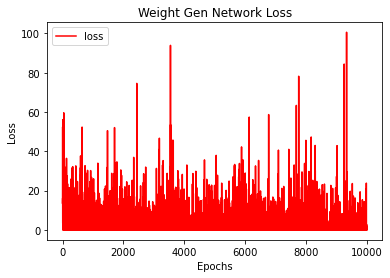

In [16]:
import matplotlib.pyplot as plt

plt.plot(flosses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


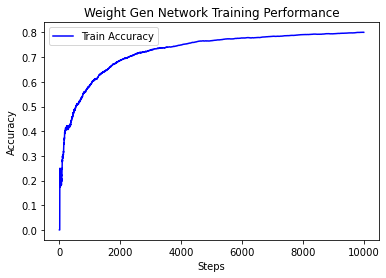

In [17]:
import matplotlib.pyplot as plt

plt.plot(ftrain_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

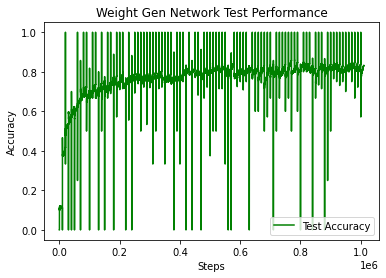

In [18]:
plt.plot(ftest_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

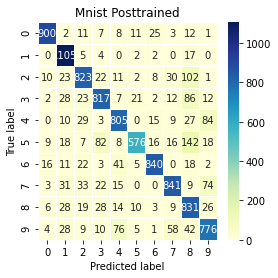

In [23]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = ftest_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Posttrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

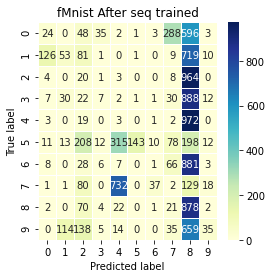

In [24]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Perfomrance Evals
dataset = test_dataset
preds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred = test_step(xt, yt)
    preds.append(pred)
tstacc_fn.reset_states()

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('fMnist After seq trained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:

"""